<a href="https://colab.research.google.com/github/krisaalstad/BayesCrash/blob/main/BayesCrash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A crash course on Bayesian methods

![The reverend Thomas Bayes](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)
<center>Possible portrait of The Reverend Thomas Bayes (c. 1701–1761).</center>

This notebook provides an introduction to Bayesian methods where we try to cover some of the most important probabilistic ideas and numerical methods for Bayesian inference in geophysics based on lectures we have given in the UiO MSc/PhD course GEO4300/GEO9300 Geophysical Data Science. The aim is to give you a basic toolkit to get a better understanding of Bayesian inference and its applications to geophysical **data assimilation**, **inverse modeling, geostatistics, and probabilistic machine learning**.

Please reach out to Kristoffer Aalstad (kristoffer.aalstad@geo.uio.no) if you spot any typos, errors, or have any feedback.


## Outline

- **Introduction**
    - Probability theory rejoinder
    - Bayes' rule
    - Philosophy of probability
- **Bayes' rule for Gaussians**
    - A simple Gaussian noise model
    - Single update
    - Synthetic Blindern climatology
    - Grid approximation
    - Bayesian filtering
- **Revisiting GISTEMP: Bayesian linear regression**
    - A simple Gaussian linear model
    - Standardization
    - Bayes' rule for Gaussians again
    - Grid approximation
    - Rescaling
    - Importance sampling: Indirect Monte Carlo
    - Markov Chain Monte Carlo (MCMC)
- **A non-linear inverse problem: Flux inversion**
    - The law of the wall
    - Importance sampling
    


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# Introduction

Frequentist (sampling) statistics is often referred to as "classical" statistics since it has historically been the statistics that working scientists and engineers are familiar with. It originates in the early 20th century with the work of Fisher, Neyman, and others, resulting in familiar terminology like statistical significance, confidence intervals, and the likelihood function. Loosely speaking, we can say that in **frequentist statistics we treat data as random variables** while parameters have a fixed (deterministic) yet unknown true value. Similarly, hypotheses can either be objectively true or false but speaking of the probability of a hypothesis does not make sense to a "frequentist".

Bayesian statistics, also known as inverse probability, is actually much older than frequentist statistics with roots back to Bayes and Laplace in the 18th century. Loosely speaking, in **Bayesian statistics treat parameters as random variables** while the data is fixed. Unlike frequentist statistics, all of Bayesian statistics essentially follows from the basic rules of probability theory.  So a "Bayesian" can entertain the probability of essentially anything. More on this later. For better or worse, Bayesian statistics is less like a cookbook of tests and procedures familiar from frequentist statistics and is instead more of a unified workflow involving a calculus of probabilities. This "probability calculus" quickly becomes very challenging in practice and explains why Bayesian methods fell out of favor in the 20th century, but is experiencing a revival thanks to the exponential growth in computing capabilities (hardware) and software tools like probabilistic programming languages (e.g. Stan, PyMC, Turing.jl).

While this crash course naturally has a heavy focus on Bayesian statistics, both types of statistics are invaluable tools in the toolkit of a geophysical data scientist. Which approach to adopt depends on the problem at hand, and often the two are highly synergistic as we will see.  While the history of statistics is marked by strong conflicts between "frequentists" and "Bayesians", in modern statistics these schools exist in unison as the two faces of statistics.

## Probability theory rejoinder


Bayesian inference builds on the two elementary rules of probability theory, namely the **product (conditioning) rule**

$$ p(\mathbf{u},\mathbf{v})=p(\mathbf{u}|\mathbf{v})p(\mathbf{v})= p(\mathbf{v}|\mathbf{u})p(\mathbf{u})$$

relating joint ("and": the $,$ symbol) and conditional ("given": the $|$ symbol) probabilities as well as the **sum (marginalization) rule**

$$ p(\mathbf{u})=\int  p(\mathbf{u},\mathbf{v}) \, \mathrm{d}\mathbf{v} $$

relating marginal $p(\mathbf{u})$ and joint probabilities $p(\mathbf{u},\mathbf{v})$ where the integral is (implicitly) over all possible values (called the **support**) of $\mathbf{v}$ . These rules hold for probability densities involving any **vectors of continuous random variables** $\mathbf{u}$ and $\mathbf{v}$, as well as for discrete random variables with minor modifications. In addition to general Bayesian inference, more applied fields like data assimilation, inverse modeling, geostatistics, and machine learning can all be understood probabilistically whereby these two rules are foundational. Long story short, as a geophysical data scientist I would recommend you to learn these two elementary rules if you have not already!

In the back of your mind, it is also a good idea to remember that by definition all these probability densities must integrate to one over their support. For example:
$$ 1 = \int p(\mathbf{u}) \mathrm{d}\mathbf{u} $$
which can be a useful constraint to keep in mind and verify when you infer a probability density. Finally, there is the humorously named **law of the unconscious statistician** (LOTUS) which tells us how to obtain an expectation of some function $g(\mathbf{u})$ with respect to a density $p(\mathbf{u})$
$$ \mathrm{E}\left[g(\mathbf{u})\right] = \int g(\mathbf{u}) p(\mathbf{u}) \, \mathrm{d}\mathbf{u} $$
for example if $g(\mathbf{u})=\mathbf{u}$ we recover the mean $\boldsymbol{\mu}$ and if $\mathbf{g}(\mathbf{u})=(\mathbf{u}-\boldsymbol{\mu})^2$ we recover the variance. This LOTUS also holds for conditional densities, for example the expectation of $g(\mathbf{u})$ with respect to $p(\mathbf{u}|\mathbf{v})$ is
$$ \mathrm{E}\left[g(\mathbf{u})|\mathbf{v}\right] = \int g(\mathbf{u}) p(\mathbf{u}|\mathbf{v}) \, \mathrm{d}\mathbf{u} $$

## Bayes' rule

When combined, the above rules yield the engine at the core of Bayesian statistics which is the so-called Bayes' rule

$$ p(\boldsymbol{\theta}|\mathbf{y}) = p(\mathbf{y}|\boldsymbol{\theta})p(\boldsymbol{\theta})/p(\mathbf{y}) $$


that is used to infer (update beliefs about) uncertain parameters $\boldsymbol{\theta}$ given some data $\mathbf{y}$. The elements in Bayes' rule are:
   - $p(\boldsymbol{\theta})$ : The **prior distribution** reflecting our model's initial beliefs about the parameters $\boldsymbol{\theta}$.
   - $p(\mathbf{y}|\boldsymbol{\theta})$: The **likelihood** which measures how 'likely' the given data $\mathbf{y}$ would be conditioned on a particular parameter vector $\boldsymbol{\theta}$. Note that, unlike the prior, this is *not* a probability density since here the data are given (fixed realizations) rather than a random variable. As such, the likelihood should be viewed as a function of the parameters $\boldsymbol{\theta}$ that loosely speaking measures the goodness of fit of the model to the data under a particular parameter setting $\boldsymbol{\theta}$.
   - $p(\mathbf{y})$: The so-called **evidence** (or marginal likelihood) which is a normalizing constant. This is a measure of the likelihood of the probabilistic model as a whole taking into account both model accuracy and model complexity. We will return to this briefly later.
   -  $p(\boldsymbol{\theta}|\mathbf{y})$: The **posterior distribution** reflecting beliefs about the parameters after having conditioned on (learned from) the data. This is the target quantity (i.e. the answer) in most Bayesian inference that tells us everything we can know (at this point) about the parameters (or other hidden variables) and their uncertainty. We can also use this object to obtain (well defined) optimal estimates with uncertainty quantification.

Some English and/or Norwegian speakers might be surprised to know that the Latin term "data" actually means "that which is given" as is also evident in Latin languages like French for example. As such, Bayes' rule provides a recipe for updating beliefs about uncertain unobservable hidden variables by conditioning on that which is given, namely the data, while taking into account sources of error in the (observed or modeled) data. This is one of the key differences between frequentist and Bayesian statistics, frequentists view the data as a random variable and the parameters as fixed (but unknown) whereas Bayesians follow the so-called **likelihood principle** by viewing the data as fixed (realizations of random variables) and the parameters as random variables. A helpful way to think about Bayesian updating is that it allows us to "invert" hidden causes from observable effects. Thus, using Bayesian inference to obtain the posterior was for a long time known as "inverse probability" since the likelihood is a kind of "forward probability".

For the potential purists out there, we are strictly being a bit lazy with notation and we should write something like $\mathbf{Y}=\mathbf{y}$ inside the probability densities to emphasize that the data $\mathbf{y}$ are a particular realization of a random variable $\mathbf{Y}$. This kind of notation quickly gets tedious however, so just remember that here we will always consider the data as given (rather than random). For the same reason, I generally do not capitalize random variables like the parameter vector $\boldsymbol{\theta}$. In general you should just remember that everything *except* the data is potentially a random variable. Here I follow the convention in most literature on Bayesian statistics such as the great (and freely available) books [BDA3](http://www.stat.columbia.edu/~gelman/book/) by Andrew Gelman et al. on statistics, [PML1](https://probml.github.io/pml-book/book1.html) and [PML2](https://probml.github.io/pml-book/book2.html) by Kevin Murphy on machine learning, [BFS](https://users.aalto.fi/~ssarkka/pub/bfs_book_2023_online.pdf) by S&auml;rkk&auml; and Svensson on filtering and smoothing, and [DAF](https://link.springer.com/book/10.1007/978-3-030-96709-3) by Evensen et al on data assimilation.

## Philosophy of probability

Without getting bogged down too deep in epistemology (the theory of knowledge), it is helpful to make a strong philosophical distinction between the Bayesian statistics covered here and the more "classical" frequentist statistics. In fact, the key difference between these approaches is not the use of Bayes' rule per se but rather in their **interpretation of probability**. I will try to briefly sketch out these differences here, since it is important for understanding statistics and deciding which approach is suitable for a particular problem. Crucially, both schools of statistics are invaluable tools in the toolkit of a geophysical data scientist. If you are interested in the links between philosophy and statistics, and why this is important for practicing scientists, I can strongly recommend the short book [Thinking About Statistics](https://doi.org/10.4324/9781003319061) by Jun Otsuka.

As the name suggests, for a frequentist probability represents the **relative frequency** of the occurrence of an event in an infinite number of repeated trials. Thus, when a frequentist states that the probability of a fair coin landing heads is $0.5$ this is referring to the relative frequency of heads in a long (strictly infinite) sequence of coin tosses. Note that strictly speaking a frequentist would not assign a probability to a single trial, the coin will either land heads or it will land tails, but rather to an infinite collection of trials. Moreover, a frequentist would not assign probability to anything that is not repeatable, which rules out statements like "the probability of rain tomorrow" or "the probability of a hypothesis being true". This explains why in frequentist statistics parameters are not random variables, they are considered to have a single true (albeit unknown) value. In summary, for frequentists probability is a measure of random ("aleatoric") uncertainty that exists externally to us in the world out there as an intrinsic property of nature.

For a Bayesian probability is just an agent's **degree of belief**. Thus, when a Bayesian states that the probability of a fair coin landing heads is $0.5$ they (or their model) believes that the coin is as likely to end up heads or tails. Unlike a frequentist, a Bayesian would be happy to assign a probability to the next coin toss. The same applies to any one time event, be it in the past, future, or present. This includes both "the probability of rain tomorrow" and "the probability of a hypothesis being true". This explains why a Bayesian is happy to consider parameters as random variables when they are uncertain about these parameters. In fact, for a Bayesian it would be more instructive to refer to random variables as uncertain variables instead since a Bayesian would tend to attribute apparent randomness in the world to lack of knowledge (uncertainty). In summary, for Bayesians probability is a measure of knowledge ("epistemic") uncertainty of an agent with a model of the world.

On the one hand, a frequentist is typically concerned with finding a single optimal "true" set of parameters, often accompanied by confidence intervals. On the other hand, a Bayesian is interested in inferring the full set of possible outcomes that are consistent with some agent's uncertainty given the data at hand. Unlike frequentist approaches, Bayesian methods are thus "subjective", but this is arguably a strength since the entire method is transparent, open to criticism, and reproducible. In fact, Bayesian inference can be seen as a probabilistic extension of ordinary binary logic that allows agents to operate rationally in the face of uncertainty, which can be justified (for example) based on arguments related to optimal betting strategies. Moreover, nothing stops Bayesian methods from using the actual frequencies of outcomes to calibrate their uncertainty estimate to the real world. In fact, this kind of "calibration" is recommended practice in Bayesian workflow and a nice example of frequentist-Bayesian synergy. Another important synergy between the two schools of statistics is that the most general computational methods to perform Bayesian inference, so-called **Monte Carlo methods** which we will cover later in this notebook, work based on frequentist (sampling) arguments.

# Bayes' rule for Gaussians

## A Gaussian noise model

Finally, we are ready for a worked example. Let's start out simple with a [spherical cow](https://en.wikipedia.org/wiki/Spherical_cow) model


![A spherical cow](https://upload.wikimedia.org/wikipedia/commons/2/23/SphericalCow2.gif)
<center>A spherical cow.</center>

namely one dimensional Gaussian updating. Even if this is one of the simplest examples of Bayesian inference, this is an example of **Bayes' rule for Gaussians** which is at the core of popular algorithms like the **Kalman filter, Kriging**, and the more general concept of **Gaussian processes**. As a first step, we construct the following data generating (or forward) model
$$ y = x + \varepsilon$$
which states how some **noisy data** $y$ are related to a **hidden variable** $x$ that has been corrupted by some noise $\varepsilon$. We assume that this is independent, zero-mean, additive Gaussian noise of the form $\varepsilon\sim \mathrm{N}(0,\sigma_y^2)$ where $\sigma_y^2$ is the noise variance. This is a particularly simple noise model that is nonetheless widely applied and can be justified using arguments such as the central limit theorem or maximum entropy. We have not said anything yet about what the **data generating model** (DGM) represents, other than the fact that it generates a noisy version of $x$ in the form of $y$. For example, the noise model could represent a combination of processes such as various sources measurement error.  


To make things more concrete, let's imagine that we have been given some data $\mathbf{y}=[y_1,\dots,y_i,\dots,y_N]$ in the form of annual mean air temperatures that (to a first order) we believe can be reasonably described by our simple DGM. In this case, the index $i$ is a time index over years, the noise $\varepsilon$ represents internal climate variability, and $x$ is the 'background' climatological mean air temperature. Our task now is to infer $x$ given $\mathbf{y}$, namely the posterior $p(x|\mathbf{y})$.


As a first step, we can define our likelihood ("forward probability"). Our DGM assumes that the data are conditionally independent given $x$ so the joint likelihood over two data points factorizes as follows
$$p(y_1,y_2|x)=p(y_1|x,y_2)p(y_2|x)=p(y_1|x)p(y_2|x)$$
or equivalently
$$p(y_1,y_2|x)=p(y_2|x,y_1)p(y_1|x)=p(y_2|x)p(y_1|x)$$
since $p(y_1|x,y_2)=p(y_1|x)$ and $p(y_2|x,y_1)=p(y_2|x)$ due to conditional independence. Extending this, the joint likelihood over all data factorizes to
$$p(\mathbf{y}|x)=p(y_1,\dots,y_i,\dots,y_N|x)=p(y_1|x)p(y_2|x)\dots p(y_i|x)\dots p(y_N|x)=\prod_{i=1}^N p(y_i|x)$$
with the following **Gaussian likelihood function** for an individual data point $y_i$:
$$p(y_i|x)=\mathrm{N}(y_i|x,\sigma_y^2)=\frac{1}{\sqrt{2\pi}\sigma_y}\exp\left(-\frac{(y_i-x)^2}{2\sigma_y^2}\right)$$
with mean $x$ and variance $\sigma_y^2$. Recall that, according to the likelihood principle, this is a function of the unknown random variable $x$ and not the fixed data $y_i$. It is not a probability distribution over $x$ since it generally does not integrate to $1$ with respect to $x$.

Secondly, we can define a prior over the climatological mean air temperature $x$. Assuming we know something about the background climate, it may be reasonable to use a **Gaussian prior** of the form
$$p(x)=\mathrm{N}(x|\mu_0,\sigma_0^2)=\frac{1}{\sqrt{2\pi}\sigma_0^2}\exp\left(-\frac{(x-\mu_0)^2}{2\sigma_0^2}\right)$$
where the prior mean $\mu_0$ can be our first guess at a typical value for the climatological mean with the prior variance, $\sigma_0^2$, representing our uncertainty.

## Single update


Depending on your experience with probability theory, even this spherical cow example might be starting to get out of hand. So let's split it up into smaller pieces and start by first just updating our beliefs on a single piece of data, namely by conditioning on $y_1$ which is the first year in our temperature data. Plugging our prior and likelihood into Bayes' rule yields
$$ p(x|y_1)=\frac{p(y_1|x)p(x)}{p(y_1)} $$
where combining the sum and product rule, we see that the evidence
$$ p(y_1) = \int p(x,y_1) \, \mathrm{d}x = \int p(y_1|x)p(x) \, \mathrm{d}x $$
does not depend on $x$ and is just a normalizing constant which we will denote $Z_1=p(y_1)$. Thus, we can simplify Bayes' rule to
$$ p(x|y_1) \propto p(y_1|x) p(x) $$
where $\propto$ means proportional (up to a normalizing constant, here $Z_1$). So in general the posterior is proportional to the product of the likelihood and the prior.

Here both the likelihood and prior are Gaussian and the product of Gaussians is also $\dots$ Gaussian! This is an example of a **conjugate prior** (the prior and posterior are of the same form) where we might have an analytical solution for the posterior distribution. Back in the day, Bayesian inference was only tractable in special cases with such 'conjugate priors'. So we know that the posterior must also be of the following Gaussian form $p(x|y_1)=\mathrm{N}(x|\mu_1,\sigma_1^2)$ where we use the suggestive notation $\mu_1$ and $\sigma_1^2$ for the posterior mean and variance, respectively, after having updated using $y_1$.

We can plug in the Gaussian likelihood and Gaussian prior into the expression for the posterior to obtain
$$ p(x|y_1) \propto \exp\left(-\frac{(y_1-x)^2}{2\sigma_y^2}\right)\exp\left(-\frac{(x-\mu_0)^2}{2\sigma_0^2}\right) $$
where constants are absorbed in the proportionality ($\propto$), which can be combined to form
$$ p(x|y_1) \propto \exp\left(-\frac{(y_1-x)^2}{2\sigma_y^2}-\frac{(x-\mu_0)^2}{2\sigma_0^2}\right)  $$
now we would like to convert the above expression to recover the more familiar form of a Gaussian $\mathrm{N}(x|\mu_1,\sigma_1^2)$. Although there are many ways of doing this, one elegant approach is to use gradient-based optimization. First, let's plot a good old Gaussian

Text(0.5, 1.0, 'Gaussian')

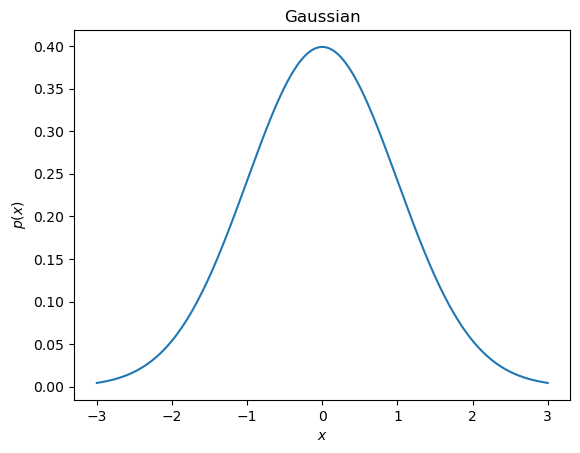

In [3]:
import numpy as np

dx=0.01
x=np.arange(-3,3+dx,dx)
mu=0
sig=1

def Gaussian(x,mu,sig):
    exponent=-0.5*((x-mu)**2)/(sig**2)
    normc=1/(np.sqrt(2*np.pi)*sig)
    px=normc*np.exp(exponent)
    return px

px=Gaussian(x,mu,sig)
plt.plot(x,px)
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.title('Gaussian')


This is hopefully familiar, and you may recall that the mean, median and mode of a Gaussian are all the same. By inspecting the plot above, we note that the only place where the gradient of the Gaussian (with respect to $x$) is zero is at the mode which happens to also be the mean. We can use this to find our posterior mode since mathematically it means
$$ \frac{\partial p}{\partial x}\Big|_{x=\mu_1}=0 $$
where $p=p(x|y_1)$ is  a shorthand for the posterior. Instead of working with the posterior directly, let's use a mathematical "trick" and define the so-called **negative log posterior** (NLP)
$$\phi(x) = -\log(p(x|y_1)) = \frac{(y_1-x)^2}{2\sigma_y^2}+\frac{(x-\mu_0)^2}{2\sigma_0^2} + c$$
where $c$ are constants that do not depend on $x$. Through the chain rule we have that
$$ \frac{\partial \phi}{\partial x} = - \frac{\partial \log(p)}{\partial p}\frac{\partial p}{\partial x} = -\frac{1}{p}\frac{\partial p}{\partial x} $$
where we observe that since for a Gaussian $p(x|y_1)>0$ (albeit sometimes extremely small) for all $x$ then the gradient of $p(x|y_1)$ and $\phi(x)$ with respect to $x$ both conveniently vanish at exactly the same value(s) of $x$. That is to say, finding the mode or "maximum a posteriori" ($x$ that maximizes $p(x|y_1)$) is the same as finding the $x$ that minimizes the NLP $\phi(x)$. Since we are dealing with a Gaussian we also know that this optimal value for $x$ is unique, and occurs at the posterior mean. Now we could proceed to find the posterior mean using gradient descent, but let's see if we can't arrive at an analytical solution by first evaluating
$$\frac{\partial \phi}{\partial x}=\frac{x-y}{2\sigma_y^2}+\frac{x-\mu_0}{2\sigma_0^2}$$
Inserting for $x=\mu_1$ so we are at the posterior mean where the gradient vanishes
$$0=\frac{\mu_1-y}{2\sigma_y^2}+\frac{\mu_1-\mu_0}{2\sigma_0^2}$$
which by multiplying out the common factor $2$ simplifies to
$$0=\frac{\mu_1-y}{\sigma_y^2}+\frac{\mu_1-\mu_0}{\sigma_0^2}$$
we can now rearrange the above to solve for $\mu_1$ and simplifying we obtain
$$\mu_1=\mu_0+K_0\left(y_1-\mu_0\right)$$
where we have defined a so-called Kalman gain term $0< K_0 < 1$
$$K_0=\frac{\sigma_0^2}{\sigma_0^2+\sigma_y^2}$$
so the updated posterior mean $\mu_1$ is equal to the prior mean $\mu_0$ plus a so-called increment (or residual) $y_1-x$ times a weighting of the uncertainty in the prior relative to the uncertainty in the data . In particular we note that as $K_0\to 0$ when $\sigma_y>>\sigma_0$ and $K_0\to 1$ when $\sigma_0>>\sigma_y$. Note that the update can also be written as
$$\mu_1=(1-K_0)\mu_0+K_0y_1$$
where it is clear that the posterior mean is a weighted sum of the prior mean and $y_1$. Using similar reasoning, based on [Laplace's approximation](https://en.wikipedia.org/wiki/Laplace%27s_approximation) which is exact for Gaussians, the posterior precision $\sigma_1^{-2}$ (the inverse variance) is given by the Hessian (second derivative) of the NLP
$$\sigma_1^{-2} = \frac{\partial^2 \phi}{\partial^2 x}\Big|_{x=\mu_1}$$
In this case, we see that the Hessian is particularly easy to evaluate and is a constant (not a function of $x$)
$$\sigma_1^{-2}=\frac{\partial^2 \phi}{\partial^2 x} = \sigma_y^{-2}+\sigma_0^{-2}$$
that is equal to the sum of the observation and prior precision. So this means that the posterior precision is always higher than both the data precision $\sigma_y^{-2}$ and the prior precision $\sigma_0^{-2}$. Taking the reciprocal of this expression, the posterior variance is
$$\sigma_1^2=\frac{\sigma_y^2\sigma_0^2}{\sigma_0^2+\sigma_y^2}=\sigma_y^2 K_0$$
or equivalently
$$\sigma_1^2=\sigma_0^2(1-K_0)$$
where since $0<K_0<1$ then $\sigma_1^2 < \sigma_y^2$ and simultaneously $\sigma_1^2<\sigma_0^2$, so the posterior variance $\sigma_1^2$ is less than both the prior variance $\sigma_0^2$ and the noise variance $\sigma_y^2$. Now  we have a closed form expression for the posterior in the by now familiar Gaussian form
$$p(x|y_1)=\frac{1}{\sqrt{(2\pi)}\sigma_1^2}\exp\left(-\frac{(x-\mu_1)^2}{2\sigma_1^2}\right) $$
where we can plug in the expressions for both the posterior mean $\mu_1$ and variance $\sigma_1^2$.

## Synthetic Blindern climatology


To reduce the risk of getting lost in math, let's now try to visualize this Bayesian updating with this simple "climate generating" model by creating some synthetic data using values from the Blindern meteorological station (SN18700) for the current climate normal period (1991-2020) obtained from the [seklima](https://seklima.met.no/) service of the Norwegian Meteorological Institute.

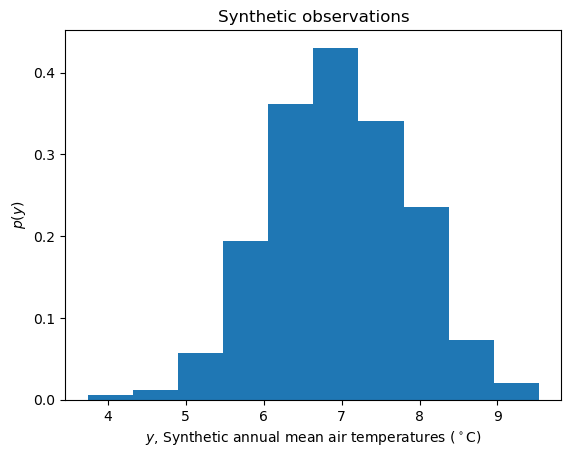

In [4]:
xtrue=6.9429 # The "true" background climatological mean, based on the sample mean
sigy=0.85 # The "true" standard deviation, based on the sample std

# Function to sample from the DGM
def sample_DGM(xin,sigy):
    y=xin+(sigy*1)*np.random.randn(N,1)
    return y

# Synthetic annual mean air temperatures
N=int(1e3) # Number of years
y=sample_DGM(xtrue,sigy)

plt.hist(y,density=True)
plt.xlabel('$y$, Synthetic annual mean air temperatures ($^\circ$C)')
plt.ylabel('$p(y)$')
plt.title('Synthetic observations')


# Extract the first year
y1=y[0]

That looks pretty Gaussian. Now let's forget that we "know" the background climate `xtrue` and instead see if we can infer this starting with a vague Gaussian prior as our first guess.

Text(0.5, 1.0, 'Prior')

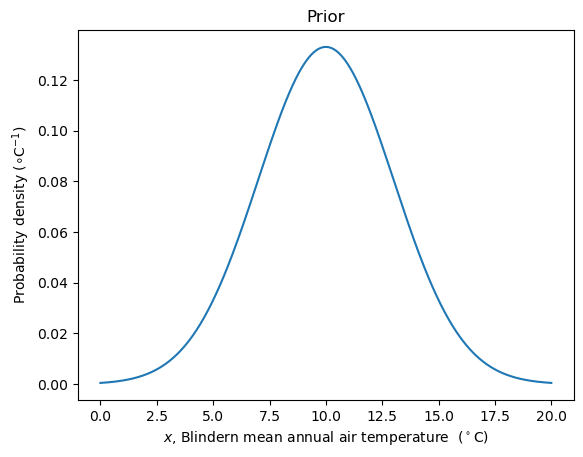

In [5]:
mu0=10 # Prior mean
sig0=3 # Prior standard deviation

dx=0.025
x=np.arange(0,20+dx,dx)

def Gaussian(x,mu,sig):
    exponent=-0.5*((x-mu)**2)/(sig**2)
    normc=1/(np.sqrt(2*np.pi)*sig)
    px=normc*np.exp(exponent)
    return px

p0=Gaussian(x,mu0,sig0)
plt.plot(x,p0)
plt.xlabel('$x$, Blindern mean annual air temperature  ($^\circ$C)')
plt.ylabel('Probability density ($\circ$C$^{-1}$)')
plt.title('Prior')

Feel free to design a (Gaussian) prior that you find reasonable, this roughly reflects my own vague prior belief that the mean annual air temperature at Blindern is probably ($P>0.99$) somewhere between 0 and 20 degrees C and most probably around 10 degrees. Having lived in Oslo for a while, my prior is not as vague as someone who has never lived here but also likely much more vague than the manager of the Blindern meteorological station. The fact that the prior is subjective is fine, **there is no "true" or "false" prior there are just better or worse priors** in terms of accurately inferring the underlying (but generally unknown) truth.

Now we are ready to code up the single update Bayes' rule for Gaussians that we derived above and try it in practice.

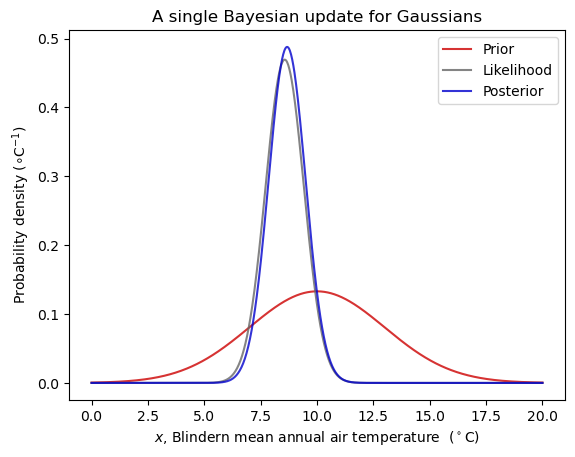

In [6]:
def SingleUpdate(mu_pri,sig_pri,ysingle,sigy):
    K=(sig_pri**2)/(sig_pri**2+sigy**2)
    mu_post=mu_pri+K*(ysingle-mu_pri)
    sig_post=np.sqrt((sigy**2)*K)
    return mu_post,sig_post

mu1,sig1=SingleUpdate(mu0,sig0,y1,sigy)
lik1=Gaussian(y1,x,sigy)
p1=Gaussian(x,mu1,sig1)
#facecolor=(.18, .31, .31)
plt.plot(x,p0,color=(0.8, 0, 0),alpha=0.8,label='Prior')
plt.plot(x,lik1,color=(0.4, 0.4, 0.4),alpha=0.8,label='Likelihood')
plt.plot(x,p1,color=(0,0,0.8),alpha=0.8,label='Posterior')
plt.xlabel('$x$, Blindern mean annual air temperature  ($^\circ$C)')
plt.ylabel('Probability density ($\circ$C$^{-1}$)')
plt.title('A single Bayesian update for Gaussians')
plt.legend()

That looks pretty good, already after the update our posterior mean is much closer to the unknown `xtrue` with a considerably smaller standard deviation that is even smaller than the noise standard deviation $\sigma_y$  as  expected:

In [7]:
print('Prior mean=%4.2f, prior std=%4.2f' % (mu0,sig0))
print('Posterior mean=%4.2f, posterior std=%4.2f' % (mu1,sig1))
print('True value=%4.2f' % xtrue)
print('Noise std=%4.2f' % sigy)

Prior mean=10.00, prior std=3.00
Posterior mean=8.67, posterior std=0.82
True value=6.94
Noise std=0.85


## Grid approximation
It's good practice to verify our solution numerically because it's only human to make mistakes especially when deriving analytical solutions. One approach that will always work in small problems is to perform a **grid approximation** of the posterior, similar to the grid search used for optimization. The idea here is simple, we just plug in the pointwise value of the unnormalized posterior at each point on a grid and then normalize by the evidence which we can obtain through numerical integration. So mathematically, we simply evaluate $p(y_1|x_j)p(x_j)$ for $J$ points $j=1,\dots,J$ on a (here 1D) grid and then approximate $Z_1$ using numerical integration to obtain estimates of the pointwise values of $p(x_j|y_1)=p(y_1|x_j)p(x_j)/Z_1$ on this grid. Recall that we have already evaluated the prior (`p0`) and likelihood pointwise (`lik1`) along a 1D grid namely the array `x`, so this should be fairly easy.

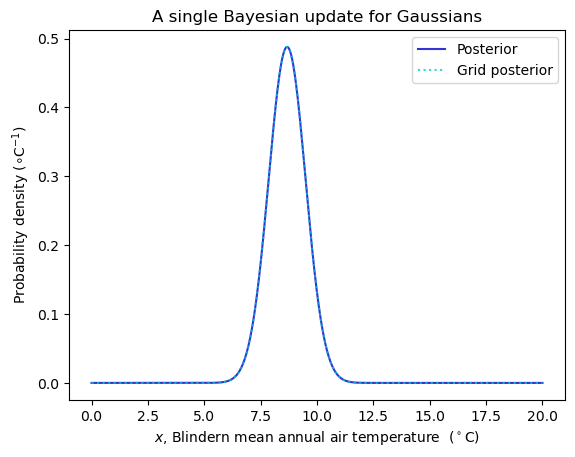

In [8]:
unpost1=lik1*p0 # The unnormalized posterior p(y_1|x_j)p(x_j)
Z1=np.trapz(unpost1,x) # Trapezoidal numerical integration
pg1=unpost1/Z1 # The grid approximation of the posterior p(x|y_1)

plt.plot(x,p1,color=(0,0,0.8),alpha=0.8,label='Posterior')
plt.plot(x,pg1,':',color=(0,0.8,0.8),alpha=0.8,label='Grid posterior')
plt.xlabel('$x$, Blindern mean annual air temperature  ($^\circ$C)')
plt.ylabel('Probability density ($\circ$C$^{-1}$)')
plt.title('A single Bayesian update for Gaussians')
plt.legend()

Great, they look identical so our analytical solution must have been correct. Of course the grid approximation was much easier to implement, but unlike the analytical solution which can be extended to larger models (with more parameters and more general linear models) the grid approximation is only really feasible up to a handful of parameters. The reason for this is the so-called **curse of dimensionality**. Let's say we wanted to infer $D=10$ parameters with $J=100$ points per dimension on a regular grid, then the grid approximation would need a total of $K=J^D=100^{10}=10^{20}$ evaluations of the pointwise posterior as well as a numerical integration over this massive multi-dimensional object. Even for considerably lower numbers of $J$ and $D$ this quickly becomes intractable and is also strongly dependent on the choice of grid spacing in each dimension.

## Bayesian dynamics

That is an encouraging start, but what about the rest of the data? We would like to infer the posterior conditioned on all the data, that is $p(x|\mathbf{y})=p(x|y_1,\dots,y_i,\dots,y_N)$. How should we go about doing that? There are two main approaches to this that yield the same result, the first is the batch (everything at once) updating approach while the second is an elegant recursive **filtering** solution. The latter also happens to be an example of dynamical updating which is something Bayesian inference is very well suited for, so let's adopt that approach since it is also simpler (no linear algebra required) especially given all the work we have done so far.  

To do this, we have to briefly revisit our basic rules of probability theory. Let's start by just adding one additional observation to the mix, $y_2$, so that we now want to infer the new posterior $p(x|y_1,y_2)$. The product rule and conditional independence helps us factorize the joint likelihood $p(y_2,y_1|x)=p(y_2|x)p(y_1|x)$ in Bayes' rule:
$$p(x|y_1,y_2)=\frac{p(y_2,y_1|x)p(x)}{p(y_1,y_2)}=\frac{p(y_2|x,y_1)p(y_1|x)p(x)}{p(y_1,y_2)}=\frac{p(y_2|x)p(y_1|x)p(x)}{p(y_1,y_2)}$$
The joint evidence in the denominator can also be factorized starting with the sum (marginalization) rule
$$p(y_1,y_2)=\int p(y_2,y_2|x) p(x) \, \mathrm{d}x = \int p(y_2|x)p(y_1|x) p(x) \, \mathrm{d} x $$
Inserting for $p(y_1|x) p(x)=p(x|y_1)Z_1$ where $Z_1=p(y_1)$ is the evidence of the first data point then
$$p(y_1,y_2) = \int p(y_2|x)p(x|y_1)Z_1 \, \mathrm{d}x = Z_1 \int p(y_2|x)p(x|y_1) \, \mathrm{d}x $$
where we used that $Z_1$ is a constant that does not depend on $x$. Defining the conditional (on $y_1$) evidence for $y_2$ as
$$Z_{2|1}=p(y_2|y_1)=\int p(y_2|x) p(x|y_1) \, \mathrm{d}x$$
Then the joint evidence can be written as
$$p(y_1,y_2)=Z_{2|1} Z_1  $$
So the new posterior becomes
$$p(x|y_1,y_2)=\frac{p(y_2|x)p(y_1|x)p(x)}{Z_{2|1} Z_1 }$$
Recalling that $p(x|y_1)=p(y_1|x)p(x)/Z_1$ is the earlier posterior that we solved for, then this new posterior can be written as
$$p(x|y_1,y_2)=\frac{p(y_2|x)p(x|y_1)}{Z_{2|1}}$$
where we see that we can use the earlier posterior as a kind of prior. This effect motivates dynamic updating, since we can continue this recursion indefinitely. For historical reasons, this kind of recursive solution is known as "filtering". Using the same reasoning as above, we can show that
$$p(x|y_1,y_2,y_3) = \frac{p(y_3|x)p(x|y_1,y_2)}{Z_{3|1:2}}$$
where the conditional (on $y_1,y_2$) evidence for $y_3$ is
$$Z_{3|1:2}=p(y_3|y_1,y_2)=\int p(y_2|x) p(x|y_1,y_2) \, \mathrm{d}x$$
More generally we have in the same vein that once we have conditioned on $\mathbf{y}_{1:i}=[y_1,\dots,y_i]$ to obtain $p(x|\mathbf{y}_{1:i})$ then conditioning on an additional observation $y_{i+1}$ to obtain $p(x|\mathbf{y}_{1:i+1})=p(x|\mathbf{y}_{1:i},y_{i+1})$ is done as follows
$$p(x|\mathbf{y}_{1:i+1})=\frac{p(y_{i+1}|x)p(x|\mathbf{y}_{1:i})}{Z_{i+1|1:i}}$$
so this cycling of **the posterior of today becomes the prior of tomorrow** can continue indefinitely. For example if we were to have online streaming data that becomes available in near real time, we would be able to use this filtering procedure to keep our inference on track with reality. This is the key idea behind Bayesian filtering for **data assimilation** that is widely used in applications such as **numerical weather prediction** and **atmospheric reanalysis**.

We can relatively easily adapt this filtering solution to our simple Gaussian DGM of Blindern's climatology. Since for year $i+1$ we know that the product of today's Gaussian prior (yesterday's posterior) $p(x|\mathbf{y}_{1:i})=\mathrm{N}(x|\mu_i,\sigma_i^2)$ and the likelihood $p(y_{i+1}|x)=\mathrm{N}(y_{i+1}|x,\sigma_y^2)$ will also be a Gaussian that we now know the solution for since then
$$p(x|\mathbf{y}_{1:i+1})\propto p(y_{i+1}|x)p(x|\mathbf{y}_{1:i})$$
is exactly the same problem as we solved before but just with a change of index. So looping over $i=0,\dots,(N-1)$ we have the recursive solution
$$K_i=\frac{\sigma_i^2}{\sigma_i^2+\sigma_y^2}$$
$$\mu_{i+1}=\mu_i+K_i\left(y_{i+1}-\mu_i\right)$$
$$\sigma_{i+1}^2=\sigma_y^2 K_i$$
where the final $\mu_N$ and $\sigma_N$ provide us with an exact solution for the full posterior $p(x|y_1,\dots,y_N)=N(x|\mu_N,\sigma_N^2)$. Let's code this up and see it in action.

Posterior mean=7.18, posterior std=0.38
True value=6.94
Noise std=0.85


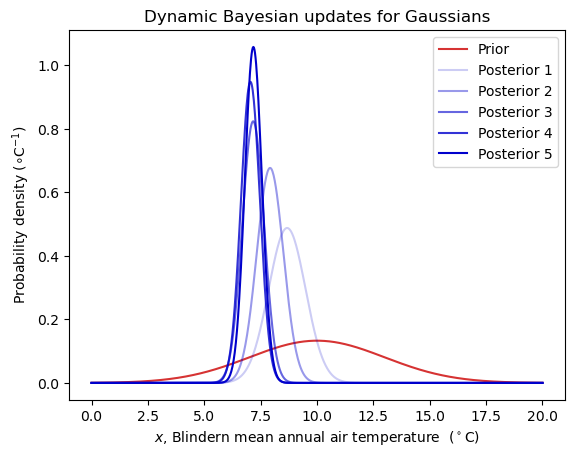

In [9]:
Nits=int(5) # Number of iterations
mu=np.zeros(Nits+1)
mu[0]=mu0
sig=np.zeros(Nits+1)
sig[0]=sig0

skiptofinal=False # Only plot final posterior (in case of large Nits)

plt.plot(x,p0,color=(0.8,0,0),alpha=0.8,label='Prior')
for j in range(Nits):
    mu[j+1],sig[j+1]=SingleUpdate(mu[j],sig[j],y[j],sigy)
    pnew=Gaussian(x,mu[j+1],sig[j+1])
    if (j+1)==Nits or skiptofinal is False:
        plt.plot(x,pnew,color=(0,0,0.8),alpha=(1.0*(j+1))/Nits,label='Posterior %d' % (j+1))

pN=pnew
plt.xlabel('$x$, Blindern mean annual air temperature  ($^\circ$C)')
plt.ylabel('Probability density ($\circ$C$^{-1}$)')
plt.title('Dynamic Bayesian updates for Gaussians')
plt.legend()

print('Posterior mean=%4.2f, posterior std=%4.2f' % (mu[-1],sig[-1]))
print('True value=%4.2f' % xtrue)
print('Noise std=%4.2f' % sigy)


Let's check this once more with a grid approximation considering all the observations that we have now conditioned on. For this it is numerically convenient to code up the full negative log posterior $\phi=-\log(p(x|\mathbf{y}))$ which can be expressed as follows thanks to the joint likelihood factorization
$$\phi(x)= \frac{(x-\mu_0)^2}{2\sigma_0^2}+\sum_{i=1}^{N}\frac{(y_i-x)^2}{2\sigma_y^2}$$

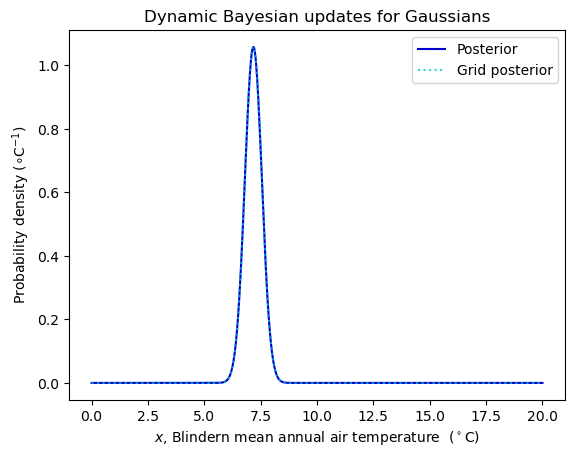

In [10]:
# We can ignore constant terms that cancel out due to the evidence (normalizing constant)
def neglogpost(xin,mu_pri,sig_pri,yin,sigy):
    res=yin-xin
    nll=(np.sum(0.5*(res**2)/sigy**2,0))
    nlpri=0.5*((xin-mu0)**2)/sig0**2
    nlp=nll+nlpri
    return nlp

unlp=neglogpost(x,mu0,sig0,y[:Nits],sigy)
unpost=np.exp(-unlp)
ZN=np.trapz(unpost,x) # Trapezoidal numerical integration
pgN=unpost/ZN # The grid approximation of the posterior p(x|y_1)

plt.plot(x,pN,color=(0,0,0.8),alpha=1,label='Posterior')
plt.plot(x,pgN,':',color=(0,0.8,0.8),alpha=0.8,label='Grid posterior')

plt.xlabel('$x$, Blindern mean annual air temperature  ($^\circ$C)')
plt.ylabel('Probability density ($\circ$C$^{-1}$)')
plt.title('Dynamic Bayesian updates for Gaussians')
plt.legend()




# Revisiting GISTEMP: Bayesian linear regression

Let's switch gears to a slightly more complex DGM and consider GISTEMP global mean annual near surface temperature anomaly data and implement the Bayesian approach to simple linear regression.  

In [11]:
#gistemp=pd.read_csv('gisstemp.csv', skiprows=1, na_values='***', index_col=0).dropna()
url='https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
gistemp=pd.read_csv(url, skiprows=1, na_values='***', index_col=0).dropna()
gistemp.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
Year,,,,,,,,,,,,,,,,,,
1881,-0.20,-0.14,0.03,0.05,0.06,-0.19,0.00,-0.03,-0.15,-0.22,-0.19,-0.07,-0.09,-0.10,-0.17,0.05,-0.07,-0.18
1882,0.16,0.14,0.04,-0.17,-0.14,-0.23,-0.16,-0.07,-0.14,-0.24,-0.17,-0.36,-0.11,-0.09,0.08,-0.09,-0.15,-0.18
1883,-0.29,-0.36,-0.12,-0.18,-0.17,-0.07,-0.06,-0.13,-0.21,-0.11,-0.23,-0.11,-0.17,-0.19,-0.34,-0.15,-0.09,-0.18
1884,-0.13,-0.07,-0.35,-0.40,-0.33,-0.35,-0.30,-0.27,-0.27,-0.25,-0.33,-0.31,-0.28,-0.26,-0.10,-0.36,-0.31,-0.28
1885,-0.58,-0.34,-0.27,-0.42,-0.45,-0.43,-0.33,-0.31,-0.28,-0.23,-0.24,-0.10,-0.33,-0.35,-0.41,-0.38,-0.36,-0.25


In [12]:
T=gistemp['J-D'].to_numpy() # The noisy output
Year = gistemp.index.to_numpy() # The input/predictor

we will be using this data to create a simple Gaussian linear model and perform Bayesian linear regression.

## A Gaussian linear model

We will use this GISTEMP global annual mean surface temperature anomaly data to extend the DGM we had earlier to now consider **non-stationary climate** due to anthropogenic global warming. The new DGM is a **simple linear model** of the form
$$y_i = \beta t_i + \alpha + \varepsilon_i $$
where $\beta$ is the **slope**, $\alpha$ is the **intercept**, $y_i$ is the temperature anomaly for year $i=1,\dots,N$ and $\varepsilon_i$ is a noise term which we once again assume follows the simple zero-mean, independent, additive Gaussian form $\varepsilon_i\sim \mathrm{N}(0,\sigma_y^2)$.
Note that this can still be understood in the same background climate + climate variability (noise) form as before:
$$ y_i = x_i +\varepsilon_i $$
Just that now the background climate is no longer stationary but a linear function of time
$$ x_i=x(\alpha,\beta,t_i)=\beta t_i + \alpha $$
where $i$ still indexes time and $t_i$ is the time variable. So the latent climate state $x_i$ depends on the uncertain parameters $\beta$ and $\alpha$ and also on the deterministic input variable (predictor, covariate, regressor) $t_i$. Probabilistically, we are thus interested in inferring these uncertain parameters $\alpha$ and $\beta$ which (to simplify notation) we combine in the parameter vector $\boldsymbol{\theta}=[\alpha \, \beta]$. Once these are inferred, we can use the posterior $p(\boldsymbol{\theta}|\mathbf{y}_{1:N})$ to predict the posterior mean of $x_i=x_i(\boldsymbol{\theta},t_i)$ using LOTUS
$$ \mu_i = \int x_i(\boldsymbol{\theta},t_i) p(\boldsymbol{\theta}|\mathbf{y}_{1:N}) \, \mathrm{d}\boldsymbol{\theta}$$
and similarly the posterior variance can help us to form a kind of credible interval (the Bayesian confidence interval) where we would expect (with some probability) to find $x_i$ given $\mathbf{y}_{1:N}$
$$ \sigma_i^2  = \int (x_i(\boldsymbol{\theta},t_i)-\mu_i)^2 p(\boldsymbol{\theta}|\mathbf{y}_{1:N}) \, \mathrm{d}\boldsymbol{\theta} $$
Moreover, we can use a similar approach to compute the so-called posterior predictive interval that includes observation noise to estimate where we would expect to find new so-called "predicted observations" $\widehat{y}_i$.

Before proceeding, it is worth linking back to the earlier example by emphasizing that we can recover the previous simple Gaussian noise model as our DGM if we force the slope to zero since then $y_i=\alpha+\varepsilon_i$ where we recognize $\alpha=x$ as the stationary background climate in that case. So the previous simple noise model is a special case of simple linear regression.

This model is also an example of where the perspective of state space modeling is useful to help tread both parameters and state variables, in that $\alpha$ and $\beta$ could be arguably treated as both, as well as the fact that the distinction between the two is often blurry as emphasized in (e.g.) [BFS](https://users.aalto.fi/~ssarkka/pub/bfs_book_2023_online.pdf) by S&auml;rkk&auml; and Svensson on filtering and smoothing. From a Bayesian perspective, both parameters and state variables can be viewed as just being random (i.e. uncertain) variables that we are interested in inferring, where the difference between the two is arguably just in the time (or spatial) scale at which they are defined and the "level" of the probabilistic model at which they live.

## Standardization

For convenience, let's standardize both the input and output data before performing the Bayesian linear regression. This makes it easier to assign priors on the parameters $\alpha$ and $\beta$. Once we have standardized and performed the Bayesian linear regression, we can always (with some care) convert back to the original range of the input and output data. For this standardization, we can use min-max scaling of the input and a z-score transform of the output:

Min(t)=0.00, Max(t)=1.00
Mean(y)=-0.00, Std(y)=1.00


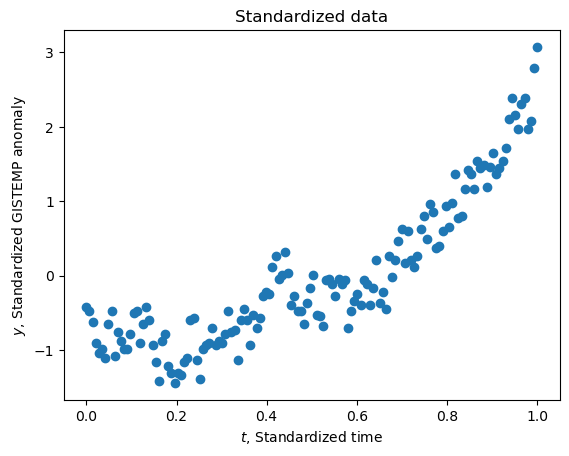

In [13]:
t=(Year-Year.min())/(Year.max()-Year.min())
y=(T-T.mean())/(T.std())

plt.scatter(t,y)
plt.xlabel('$t$, Standardized time')
plt.ylabel('$y$, Standardized GISTEMP anomaly')
plt.title('Standardized data')

# Check that we did this properly:
print('Min(t)=%4.2f, Max(t)=%4.2f' % (t.min(),t.max()))
print('Mean(y)=%4.2f, Std(y)=%4.2f' % (y.mean(),y.std()))


## Revisiting Bayes' rule for Gaussians

This simple linear DGM with zero-mean, independent, additive Gaussian noise leads to the following Gaussian likelihood

$$p(y_i|\alpha,\beta)=\mathrm{N}(y_i|x_i,\sigma_y^2)=\frac{1}{\sqrt{2\pi}\sigma_y}\exp\left(-\frac{(y_i-x_i)^2}{2\sigma_y^2}\right)$$

where we have used the shorthand $x_i=x(\alpha,\beta,t_i)=\beta t_i+\alpha$ to denote the mean of the Gaussian likelihood which is the background climate that is a **linear function** of $\alpha$ and $\beta$. As before, due to conditional independence, the joint likelihood factorizes and becomes
$$p(\mathbf{y}_{1:N}|\alpha,\beta)=\prod_{i=1}^N p(y_i|\alpha,\beta) \propto \exp\left(-\sum_{i=1}^N\frac{(y_i-x_i)^2}{2\sigma_y^2}\right) $$


Next, we need to define a prior over the parameters. This is more challenging than in the last example since it is less obvious what is a reasonable range on the slope and intercept even in the standardized space. Still, since we have standardized the output data $y_i$ with a z-score transform we do know that it's dynamic range should be similar to that of a standard Gaussian between $-3$ and $3$. So we could try to just put a vague standard Gaussian prior on $\beta$ and $\alpha$, hoping that this translates into such a dynamic range on the prior predicted data generated by the DGM. For simplicity, let's assume that the priors on $\beta$ and $\alpha$ are independent, such that
$$p(\boldsymbol{\theta})=p(\alpha,\beta)=p(\alpha)p(\beta)$$
where we assign the marginal priors are defined as 1D Gaussians with the familiar form
$$p(\alpha)=\mathrm{N}(\alpha|\tilde{\mu}_{\alpha},\tilde{\sigma}_{\alpha}^2)=\frac{1}{\sqrt{2\pi}\tilde{\sigma}_{\alpha}}\exp\left(-\frac{(\alpha-\tilde{\mu}_{\alpha})^2}{2\tilde{\sigma}_{\alpha}^2}\right)$$
$$p(\beta)=\mathrm{N}(\beta|\tilde{\mu}_{\beta},\tilde{\sigma}_{\beta}^2)=\frac{1}{\sqrt{2\pi}\tilde{\sigma}_{\beta}}\exp\left(-\frac{(\alpha-\tilde{\mu}_{\beta})^2}{2\tilde{\sigma}_{\beta}^2}\right)$$
where $\tilde{\mu}_{\alpha}$ and $\tilde{\sigma}_{\alpha}^2$ are the prior mean and variance, respectively, for $\alpha$ with analogous definitions for $\beta$. We could generalize this to a prior with dependence between parameters, for example using a multivariate Gaussian with non-zero covariance between parameters, but let's keep this simple. A good way to check if the prior is reasonable is to simulate some data using the prior. Note that using the data that you will update on to construct your prior is generally a big faux pas in Bayesian inference since this kind of "double dipping" results in circular reasoning. There are nonetheless formal procedures to do this, such as empirical Bayes, and there are certainly situations where this can be warranted but then it is important to be explicit about what is being done. More generally, using synthetic data as a guide to calibrate the prior, however, is completely legitimate and even encouraged.

Now let's code up an example:

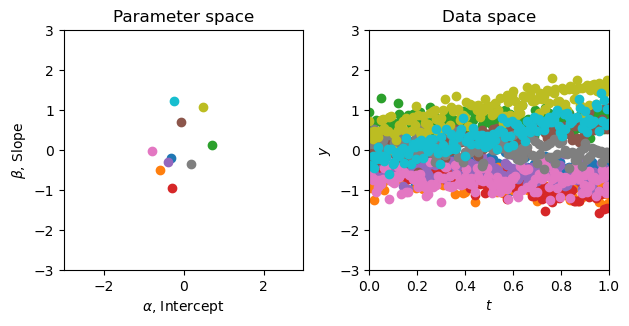

In [14]:
Nt=len(t)  # Number of time steps (years)

sigy=0.2 # The noise std in the data (y), this is a so-called "hyperparameter"

# Set the parameters of the prior (feel free to vary these and check the effect)
mu_a_pri=0 # Prior mean for alpha
sd_a_pri=1 # Prior std for alpha
mu_b_pri=0 # Prior mean for beta
sd_b_pri=1 # Prior std for beta

# Since the priors for alpha and beta are independent, we can generate
# samples from the joint prior by sampling from the marginal priors independently
# of one another.
Ns=int(10) # Number of samples

# Generate samples from these marginal Gaussian priors
a_pri=mu_a_pri+sd_a_pri*np.random.randn(Ns)
b_pri=mu_b_pri+sd_b_pri*np.random.randn(Ns)


# The linear model for x
def linear_model(tin,a,b):
    if any(a.shape):#len(a)>1:
        a=np.expand_dims(a,1)
        b=np.expand_dims(b,1)
    x=b*tin+a
    x=x.T # Array shape from (Ns,Nt) to (Nt,Ns)
    return x

# Sample the linear data generating model for y
def sample_linear_DGM(tin,a,b,sigy):
    x=linear_model(tin,a,b)
    [Nt,Ns]=x.shape
    eps=sigy*np.random.randn(Nt,Ns)
    y=x+eps
    return x,y

x,ysyn=sample_linear_DGM(t,a_pri,b_pri,sigy)

fig, (ax1, ax2) = plt.subplots(1,2)
#fig.suptitle('Vertically stacked subplots')
for j in range(Ns):
    ax1.scatter(a_pri[j],b_pri[j])
    if j==0:
        ax1.set_xlabel(r'$\alpha$, Intercept')
        ax1.set_ylabel(r'$\beta$, Slope')
        ax1.set_title('Parameter space')
        #ax1.set_aspect(0.25)
    elif j==(Ns-1):
        ax1.set_xlim([-3,3])
        ax1.set_ylim([-3,3])
        ax1.set_aspect(1)

    ax2.scatter(t,ysyn[:,j])
    if j==0:
        ax2.set_xlabel(r'$t$')
        ax2.set_ylabel(r'$y$')
        ax2.set_title('Data space')
    elif j==(Ns-1):
        ax2.set_xlim([0,1])
        ax2.set_ylim([-3,3])
        ax2.set_aspect(1/6.0)

fig.tight_layout()

This looks more or less reasonable, in the sense that we are able to generate synthetic data that spans the expected dynamic range of the data with these prior slopes and intercepts that are centered on 0 with some spread. While the underlying linearity of the model is evident there is also the noise structure superimposed on the trend that is partly consistent with how one might imagine the structure of the GISTEMP data. The noise variance hyperparameter $\sigma_y^2$ will clearly play a strong role in modulating the noise level (try changing `sigy`), and it might be that we have to adjust this in light of the data.

We once again have a Gaussian prior and a Gaussian likelihood. It turns out that, in this case as long as we have a linear data generating model then (with some linear algebra) Bayes' rule for Gaussians (see [PML2](https://probml.github.io/pml-book/book2.html)) can be generalized to as many dimensions as we like to solve analytically for a Guassian posterior. Since linear models are either directly or approximately applicable to many phenomena, this is a very powerful tool that leads to methods such as the aforementioned Kalman filter, Kriging, and Gaussian process regression. Although you are now well equipped to explore that route if you want, it requires diving into quite some linear algebra and would take the rest of the crash course. So instead, let's learn some more general **Monte Carlo algorithms** that can be applied **beyond Gaussian linear** problems. Before going down this route, however, let's first obtain the grid approximation as a partial solution for the Bayesian linear regression that we can use as a reference.

## Grid approximation

As before, let's start by defining the negative log posterior recalling that the prior factorizes $p(\boldsymbol{\theta})=p(\alpha)p(\beta)$
$$\phi(\boldsymbol{\theta})=-\log(p(\boldsymbol{\theta}|\mathbf{y}))=\frac{(\alpha-\tilde{\mu}_\alpha)^2}{2\tilde{\sigma}_\alpha^2}+\frac{(\beta-\tilde{\mu}_\beta)^2}{2\tilde{\sigma}_\beta^2}+\sum_{i=1}^N\frac{(y_i-x(\alpha,\beta))^2}{2\tilde{\sigma}_y^2}+c $$
where $c$ are constant terms that do not depend on the parameters.

Grid MAP parameters: alpha=-1.50, beta=3.00


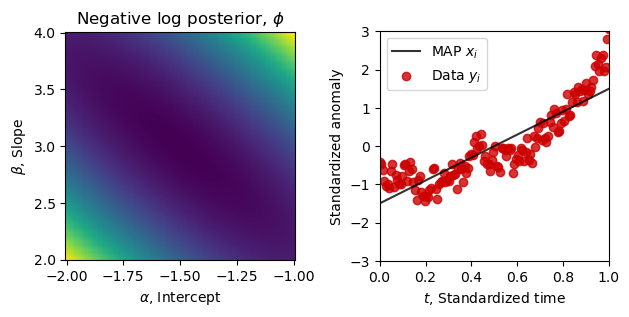

In [15]:
# We can ignore constant terms that cancel out due to the evidence (normalizing constant)
def neglogpost(a,mu_a_pri,sd_a_pri,b,mu_b_pri,sd_b_pri,tin,yin,sigy):
    xin=linear_model(tin,a,b)
    yin=np.expand_dims(yin,1)
    res=yin-xin

   # b=np.expand_dims(b,1)
   # x=b*tin+a

    nll=(np.sum(0.5*(res**2)/sigy**2,0))
    nlpri_a=0.5*((a-mu_a_pri)**2)/sd_a_pri**2
    nlpri_b=0.5*((b-mu_b_pri)**2)/sd_b_pri**2
    nlpri=nlpri_a+nlpri_b
    nlp=nll+nlpri
    return nlp

# Now let's define a grid over the 2D parameter space
dozoom=True # Zoom in to the high probability density region

if dozoom is True:
    da=0.01
    a=np.arange(-2.0,-1.0+da,da)
    db=0.01
    b=np.arange(2.0,4.0+db,db)
else:
    da=0.1
    a=np.arange(-3.0,3.0+da,da)
    db=0.1
    b=np.arange(-5.0,5.0+db,db)


[A,B]=np.meshgrid(a,b)

Ng=A.size # Number of grid cells

agf=A.flatten()
bgf=B.flatten()

nlp=neglogpost(agf,mu_a_pri,sd_a_pri,bgf,mu_b_pri,sd_b_pri,t,y,sigy)

nlp=nlp.reshape(A.shape[0],A.shape[1])

unpostab=np.exp(-1.0*nlp)

unpostb=np.trapz(unpostab,a,axis=1)
Z=np.trapz(unpostb,b,axis=0)
postab=unpostab/Z

integral_test=np.trapz(np.trapz(postab,a,axis=1),b,axis=0) # Test that this integrates to one

# The maximum a posteriori (MAP) parameters occur at the mode of the posterior,
# which is the minimum of the NLP
here=nlp==np.min(nlp.flatten())


amap=A[here]
bmap=B[here]

xmap=linear_model(t,amap,bmap)

print('Grid MAP parameters: alpha=%4.2f, beta=%4.2f' % (amap,bmap))


#plt.plot(x,lik1,color=(0.4, 0.4, 0.4),alpha=0.8,label='Likelihood')
fig, (ax1, ax2) = plt.subplots(1,2)

# Calculate the neglogpost

pc1=ax1.pcolor(a,b,nlp)
ax1.set_xlabel(r'$\alpha$, Intercept')
ax1.set_ylabel(r'$\beta$, Slope')
ax1.set_title(r'Negative log posterior, $\phi$')
ax1.set_aspect(1/2)
#cbar = fig.colorbar(pc1)
ax2.plot(t,xmap,color=(0,0,0),alpha=0.8,label='MAP $x_i$')
ax2.scatter(t,y,color=(0.8,0,0),alpha=0.8,label='Data $y_i$')
ax2.set_xlim([0,1])
ax2.set_ylim([-3,3])
ax2.set_aspect(1/6)
ax2.set_xlabel(r'$t$, Standardized time')
ax2.set_ylabel(r'Standardized anomaly')
plt.legend()

fig.tight_layout()

While this grid approximation still works, it is already considerably harder to apply in a two dimensional parameters and requires a careful (and typically adaptive) setting of the grid spacing as well as the minimum and maximum values of the parameters. Moreover, although estimating the MAP (mode) is trivial, which in this Gaussian case coincides with the posterior mean, estimating the posterior standard deviation (spread) of the latent climate to obtain a credible interval on the trend line is a bit more involved so we skip that here. The grid MAP estimates on the parameters $\alpha$ and $\beta$ as the grid MAP background climate $x_i$ will be useful as verification for the more general Monte Carlo methods that are coming up next.

## Rescaling

First, it's good to know how to plot the results and output the parameters in the original (unstandardized) space where the input is time in years and the output is some kind of temperature anomaly. So here's how to do that:

Rescaled MAP parameters: alpha=-15.98 ($^\circ$C), beta=0.0082 ($^\circ$C)/year
Rescaled MAP slope: beta=0.0822 ($^\circ$C)/decade


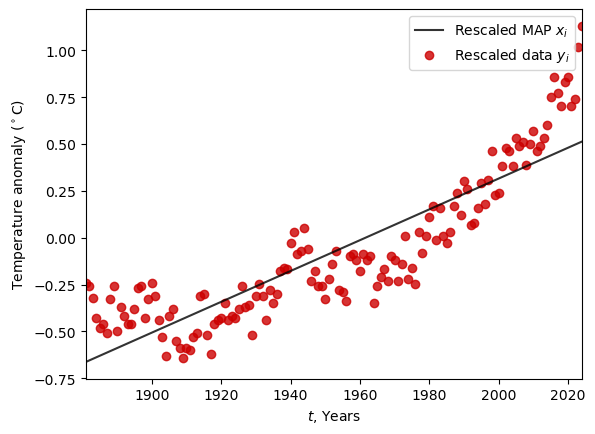

In [16]:
# To do this, we simply rescale the output (y axis) by inverting the z-score transform
# and plot Years on the x-axis
xmapre=xmap*T.std()-T.mean()
yre=y*T.std()-T.mean()

plt.plot(Year,xmapre,color=(0,0,0),alpha=0.8,label='Rescaled MAP $x_i$')
plt.scatter(Year,yre,color=(0.8,0,0),alpha=0.8,label='Rescaled data $y_i$')
plt.xlim([Year.min(),Year.max()])
#ylim([-3,3])
#aspect(1/6)
plt.xlabel(r'$t$, Years')
plt.ylabel(r'Temperature anomaly ($^\circ$C)')
plt.legend()

# Similarly, we can recover the parameters in "physical" (unstandardized) space by
# inserting for the definition of the scaled y and t in the DGM and solving for
# a slope term and an intercept term. This gives us:
delYear=Year.max()-Year.min()
bmapre=(bmap*T.std())/delYear
amapre=T.std()*amap-T.std()*bmap*Year.min()/delYear+T.mean()

# Rescaled parameters (with units)
print('Rescaled MAP parameters: alpha=%4.2f ($^\circ$C), beta=%4.4f ($^\circ$C)/year' % (amapre,bmapre))

# The slope term is the most interesting here, if we rescale it to decades that becomes
print('Rescaled MAP slope: beta=%4.4f ($^\circ$C)/decade' % (bmapre*1e1))


## Particle methods: Importance sampling

[Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) methods with roots in physics dating back to the 1940s Manhattan (atomic bomb) project offer a very powerful and general solution to numerically approximating integrals, such as posterior expectations, that appear in Bayesian inference. The **direct Monte Carlo** approach to estimating a posterior expectation of $g(\boldsymbol{\theta})$
$$E[g(\boldsymbol{\theta})]=\int g(\boldsymbol{\theta}) p(\boldsymbol{\theta}|\mathbf{y})\, \mathrm{d}\boldsymbol{\theta}$$
where we recall that the choice $g(\boldsymbol{\theta})=\boldsymbol{\theta}$ yields the posterior mean and so on, is to use the **law of large numbers** to approximate this expectation as the sum
$$E[g(\boldsymbol{\theta})] \simeq \frac{1}{N_s}\sum_{j=1}^{N_s} g(\boldsymbol{\theta}_j)$$
where the $\boldsymbol{\theta}_j\sim p(\boldsymbol{\theta}|\mathbf{y})$ are $j=1,\dots,N_s$ independent samples from the posterior obtained using (pseudo) **random number generators** available programmatically through e.g. `np.random` and friends in Python (and `rand` and friends in Matlab). From the **central limit theorem**, this estimate has a **standard error inversely proportional to $\sqrt{N_s}$**. So as the number of samples increases the standard error decreases at a rate that is independent of the dimension (size of the parameter space) of the problem. As such, Monte Carlo methods are very powerful general tools that are used in high dimensional nonlinear geophysics problems such as numerical weather (and ocean) prediction, climate simulations, and hydrological streamflow forecasting. Being able to replace complex intractable integrals with simple sums that a computer can carry out is clearly a handy tool, but note that these methods are technically a last resort (when all else fails) in that they may require quite a large number of samples $N_s$ to work well.

In our linear regression example, given $\boldsymbol{\theta}_j\sim p(\boldsymbol{\theta}|\mathbf{y})$ with $g(\boldsymbol{\theta})=x(\alpha,\beta,t_i)$ we could obtain a Monte Carlo estimate of the posterior mean of $x_i=x(\alpha,\beta,t_i)$ through the sum
$$ \mu_i = \int x(\alpha,\beta,t_i) p(\boldsymbol{\theta}|\mathbf{y})\, \mathrm{d}\boldsymbol{\theta} \simeq \frac{1}{N_s}\sum_{j=1}^{N_s} x(\alpha_j,\beta_j,t_i)=\frac{1}{N_s}\sum_{j=1}^{N_s}\left[\beta_j t_i+\alpha_j\right] $$


The big catch, however, is that we generally (outside of special cases) do not know how to generate independent samples from the posterior distribution since that is essentially the problem we are trying to solve to begin with. Thus, we need a more general Monte Carlo method. That's where **importance sampling**, an indirect Monte Carlo method, comes in. Here we will focus on the most basic (but still widely applicable) importance sampling method which is at the root of powerful methods like **particle filtering** (or **Sequential Monte Carlo**) that also involves some kind of dynamical updating. The idea behind importance sampling is that we can sample from another distribution than our actual target (the posterior) but nonetheless generate a valid Monte Carlo estimate by weighting the samples.

Let's use importance sampling to estimate $\mu_i$ the posterior mean of $x_i$. First we insert for the decomposed posterior
$p(\boldsymbol{\theta}|\mathbf{y})=p(\mathbf{y}|\boldsymbol{\theta})p(\boldsymbol{\theta})/p(\mathbf{y})$ obtained through Bayes' rule whereby
$$ \mu_i = \int x(\boldsymbol{\theta},t_i) p(\boldsymbol{\theta}|\mathbf{y})\, \mathrm{d}\boldsymbol{\theta} = \int x(\boldsymbol{\theta},t_i) \frac{p(\mathbf{y}|\boldsymbol{\theta})p(\boldsymbol{\theta})}{p(\mathbf{y})}\, \mathrm{d}\boldsymbol{\theta} $$
where $x(\boldsymbol{\theta},t_i)=x(\alpha,\beta,t_i)$ is a shorthand.

Now this does not seem to have gotten us very far yet, especially since it is not clear what to do with the evidence term $p(\mathbf{y})$ in the denominator. Recalling that this is defined as the integral
$$p(\mathbf{y})=\int p(\mathbf{y}|\boldsymbol{\theta})p(\boldsymbol{\theta}) \, \mathrm{d}\boldsymbol{\theta}$$
which can be viewed as an **expectation of the likelihood with respect to the prior** so there is hope since as is (the case with our Gaussian prior here) we often do know how to **sample from the prior** $\boldsymbol{\theta}_j\sim p(\boldsymbol{\theta})$ so given $j=1,\dots,N_s$ such independent samples we can approximate the evidence via the Monte Carlo estimate
$$p(\mathbf{y})\simeq \hat{Z} = \frac{1}{N_s}\sum_{i=1}^{N_s} p(\mathbf{y}|\boldsymbol{\theta}_j)$$'
where we have defined the shorthand $\hat{Z}$ for this Monte Carlo evidence estimate.

Now we can insert this estimate to obtain an approximation for  posterior mean of $x_i$ of the form
$$ \mu_i \simeq \frac{1}{\hat{Z}}\int x(\boldsymbol{\theta},t_i) p(\mathbf{y}|\boldsymbol{\theta})p(\boldsymbol{\theta}) \, \mathrm{d}\boldsymbol{\theta} $$
where we have taken the constant evidence estimate $\hat{Z}$ outside of the integral for clarity. Now we can take this approximation one step further by using the same samples from the prior $\boldsymbol{\theta}_j\sim p(\boldsymbol{\theta})$ to obtain a Monte Carlo estimate of the integral, which can be viewed as a prior expectation of the product of $x_i$ and the likelihood, through
$$ \mu_i \simeq \frac{1}{\hat{Z}N_s}\sum_{i=1}^{N_s} x(\boldsymbol{\theta},t_i)p(\mathbf{y}|\boldsymbol{\theta}_j)$$
Inserting for $\hat{Z}=\frac{1}{N_s}\sum_{k=1}^{N_s}p(\mathbf{y}|\boldsymbol{\theta}_k)$ this simplifies to
$$ \mu_i \simeq \sum_{i=1}^{N_s} x(\boldsymbol{\theta}_j,t_i)\frac{p(\mathbf{y}|\boldsymbol{\theta}_j)}{\sum_{k=1}^{N_s} p(\mathbf{y}|\boldsymbol{\theta}_k)} $$
which if we define the so-called normalized importance weights
$$ w_j=\frac{p(\mathbf{y}|\boldsymbol{\theta}_j)}{\sum_{k=1}^{N_s} p(\mathbf{y}|\boldsymbol{\theta}_k)} $$
where $\sum_{j=1}^{N_s} w_j=1$ then we can write estimate $\mu_i$ as through the weighted mean
$$ \mu_i \simeq \sum_j w_j x(\boldsymbol{\theta}_j,t_i) $$.


It can be shown analogously that the posterior variance of $x(\boldsymbol{\theta}_j,t_i)$ can be estimated through
$$ \sigma_i \simeq \sum_j w_j \left(x(\boldsymbol{\theta}_j,t_i)-\mu_i\right)^2 $$
Similarly, the posterior mean and variance of the parameters can be estimated through
$$ \boldsymbol{\mu}_\boldsymbol{\theta} \simeq w_j \boldsymbol{\theta}_j $$
and
$$ \boldsymbol{\sigma}_\boldsymbol{\theta}^2 \simeq w_j \left(\theta_j-\boldsymbol{\mu}_\boldsymbol{\theta}\right)^2 $$.

For the GISTEMP linear regression, recalling that
$$p(\mathbf{y}_{1:N}|\alpha,\beta)=\prod_{i=1}^N p(y_i|\alpha,\beta) \propto \exp\left(-\sum_{i=1}^N\frac{(y_i-x_i)^2}{2\sigma_y^2}\right) $$
the weights are obtained through the simple likelihood ratio
$$ w_j = \frac{\exp\left(-\sum_{i=1}^N\frac{(y_i-x(\boldsymbol{\theta}_j,t_i))^2}{2\sigma_y^2}\right)}{\sum_{k=1}^{N_s} \exp\left(-\sum_{i=1}^N\frac{(y_i-x(\boldsymbol{\theta}_k,t_i))^2}{2\sigma_y^2}\right) } $$
in practice to ensure numerical stability we first calculate the logarithm of the weights as shown below in the `BIS` function

Finally, the accuracy of these estimates can be monitored heuristically through a metric known as the **effective sample size (ESS)** which is given by
$$ \mathrm{ESS} = \frac{1}{\sum_j w_j^2} $$
in the ideal case we will have that $w_j=1/N_s$ for all samples $j$ so that $\mathrm{ESS}=N_s$ while in the worst so-called **degenerate** case where all the weight is on one sample has all the weight such that $w_j=\delta_{ij}$ [Kronecker_delta](https://en.wikipedia.org/wiki/Kronecker_delta) for some $i\in(1,N_s)$ then $\mathrm{ESS}=1$. So this ESS is a useful guide to the quality of the importance sampling estimates. Instead of working directly with the weighted particles (samples), it is also possible to resample the particles based on their weights (e.g. using `np.random.choice`) once they are obtained so as to copy high weight particles and remove low weight particles. In this way, we end up with equally weighted resampled particles and can instead use simple arithmetic (instead of weighted) means to compute the moments above.

In case anyone wants to dig deeper into these methods, I note in passing that it is possible to deign more clever and even adaptive importance sampling methods by sampling from more general proposal distributions than the prior. Indeed, such adaptive importance sampling methods share much in common with [evolutionary computing](https://en.wikipedia.org/wiki/Evolutionary_computation) methods for optimization such as the genetic algorithm that was popular in the early 2000s. Heuristically one can conceptualize these methods as obtaining the particles (samples) based on their fitness to the data, with a kind of computational Darwinian "survival of the fittest" whereby only the higher weight particles survive to the next "generation" (iteration).

Now let's code this up and see if we can finally do Bayesian linear regression using importance sampling

BIS posterior mean parameters: alpha=-0.94, beta=2.46
Effective sample size=1.00 out of 1000.00 particles


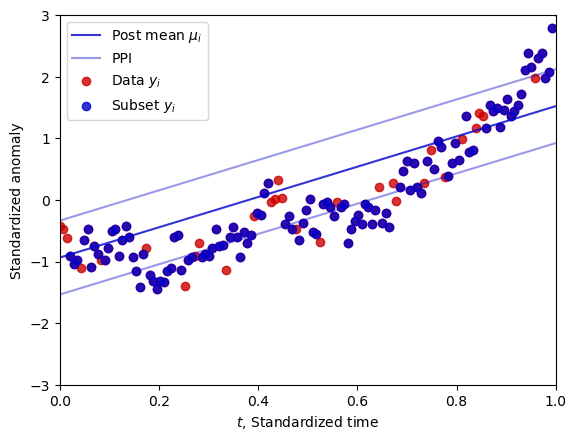

In [17]:
# Basic importance sampling (simple 'particle filtering')
def BIS(xpri,yobs,sigy):
    # Basic importance sampling (BIS)
    # Assumes we have a Gaussian prior that is also being used as the so-called
    # proposal distribution.
    # For simplicty the noise is assumed to be iid Gaussian.
    # Note that both of these assumptions can be relaxed in BIS which can
    # be used with any prior and/or likelihood.
    # In this special case the importance sampling equation simplifies a lot,
    # but performance can be improved by picking a smarter proposal.
    # Input:
    #        xpri=Prior noise-free predicted data (Nobs x Nsamples),
    #        yobs=Observation (data) vector to condition on (Nobs x 1)
    #        sigy=Noise standard deviation (Scalar).
    if len(yobs.shape)==1:
        yobs=np.expand_dims(yobs,1)
    residual=xpri-yobs
    normresidual=((xpri-yobs).T/sigy).T
    # In "BIS" the prior term cancels out with proposal, so the
    # weights are just a simple likelihood ratio (computed in log space first)
    #logw=-0.5*np.sum(residual**2,0)/(sigy**2)
    logw=-0.5*np.sum(normresidual**2,0)
    logw=logw-np.max(logw) # This is to improve numerical stability
    w=np.exp(logw)
    w=w/np.sum(w)
    Neff=1/np.sum(w**2)
    return w,Neff

# Can do basic grid search over sigy to optimize evidence

# Generate samples from the prior as before
Ns=int(1e3)
a_pri=mu_a_pri+sd_a_pri*np.random.randn(Ns)
b_pri=mu_b_pri+sd_b_pri*np.random.randn(Ns)

# Generate prior predictions of the (noise free) background climate
x_pri=linear_model(t,a_pri,b_pri)


# Option to only use a (random) subset of the years of data to check
# the effect of the number of data points in the inference. This is know
# as "data tempering" and can be done iteratively so the posterior becomes
# a new prior in a kind of "pseudo" Bayesian dynamics to improve inference.
subsetf=0.8
Nsub=int(subsetf*Nt)
thesesub=np.random.choice(Nt,Nsub,replace=False)


# Option to inflate the noise variance. This is known as "likelihood tempering"
# and can also be done iteratively to improve inference in the same way and
# even at the same time as data tempering.
inflate=1.0
# This can also be seen as a correction to the noise variance, which we may have
# actually under (or over) estimated in our first guess.

w,Neff=BIS(x_pri[thesesub,:],y[thesesub],inflate*sigy)


bpostm=b_pri@w # dot product
apostm=a_pri@w
xpostm=x_pri@w
xpostsd=np.sqrt(((x_pri-np.expand_dims(xpostm,1))**2)@w)

# Compute the 3 sigma (99.7%) posterior predictive interval for the data y
# with this noise model, this happens to revert to the so-called
# standard Gaussian "error propagation" method.
yppi=3*np.sqrt(xpostsd**2+sigy**2)
# This is useful for checking if the posterior uncertainty is well calibrated,
# in the sense that we would expect so to say all data points to fall in this PPI.


print('BIS posterior mean parameters: alpha=%4.2f, beta=%4.2f' % (apostm,bpostm))
print('Effective sample size=%4.2f out of %4.2f particles' % (Neff,Ns))

plt.plot(t,xpostm,color=(0,0,0.8),alpha=0.8,label='Post mean $\mu_i$')
plt.plot(t,xpostm+yppi,color=(0,0,0.8),alpha=0.4,label='PPI')
plt.plot(t,xpostm-yppi,color=(0,0,0.8),alpha=0.4)
plt.scatter(t,y,color=(0.8,0,0),alpha=0.8,label='Data $y_i$')
plt.scatter(t[thesesub],y[thesesub],color=(0,0,0.8),alpha=0.8,label='Subset $y_i$')
plt.xlim([0,1])
plt.ylim([-3,3])
#plt.aspect(1/6)
plt.xlabel(r'$t$, Standardized time')
plt.ylabel(r'Standardized anomaly')
plt.legend()

With some adjustments, we can get this basic importance sampling to work quite well on this Bayesian linear regression problem. For it to work and have the right coverage properties it is important to also optimize or hierarchically infer the noise variance hyperparameter $\sigma_y^2$. Note that this is not a limitation of this particular inference method, all methods will be sensitive to design choices involving method (algorithm) specific tuning parameters as well as general problem (DGM) specific hyperparameters.

## Markov chain Monte Carlo (MCMC)

Last but not least in this example, let's quickly cover the MCMC method which is the main work horse in various probabilistic programming languages that is considered the gold standard class of methods for Bayesian inference. The reason for this is that MCMC is guaranteed to converge in the long run, as we will see. One issue, however, is that "the long run" can take a very long and often computationally intractable amount of time. Note that this asymptotic convergence property of MCMC also applies to the more parallelizable importance sampling methods that we just explored in the limit of a very large (or infinite) ensemble of particles. For various, partly [historical](https://doi.org/10.1214/10-STS351), reasons it is MCMC that has been the most popular class of methods. It is also possible to combine MCMC and importance sampling using so-called "resample move" strategies or particle MCMC, but now we are getting ahead of ourselves. Let's introduce MCMC first.

We will focus on the most basic MCMC method is known as the Random Walk Metropolis (RWM) method after the seminal [paper](https://doi.org/10.1063/1.1699114) by Metropolis, Rosenbluth$^2$, and Teller$^2$ from the Manhattan project. As an aside it is somewhat unfair to attribute the method to Metropolis rather than others in the team, and in general as [Stigler's law](https://en.wikipedia.org/wiki/Stigler%27s_law_of_eponymy) ironically reminds us it's just a bad idea to name important methods after people. Nonetheless, this 'Metropolis algorithm' happens to be the name that stuck maybe because it somehow sounds impressive. Most other MCMC methods can be viewed as extensions of the basic workflow in the RWM method, so this is a good place to start learning about MCMC. If you want to explore more of these methods, check out [Chi Feng's interactive demo](https://chi-feng.github.io/mcmc-demo/).

All MCMC methods share in common that they are based on the construction of a Markov chain that strategically steps through parameter space such that in the long run we end up with (dependent) samples from the target posterior distribution of interest. Decomposing the term **Markov chain**, the *Markov* term refers to a stochastic (random) process that is **memoryless** in that the next point $\boldsymbol{\theta}_{j+1}$ in parameter space only depends directly on the current point $\boldsymbol{\theta}_j$ and not the earlier history. The *chain* term refers to the entire process being a sequence of steps, effectively a walk, through parameter space. The Markov chain is typically guided by a so-called proposal distribution denoted $q(\boldsymbol{\theta}_{*}|\boldsymbol{\theta}_j)$ which determines the probability of the next *proposed* point $\boldsymbol{\theta}_{*}$ in the chain given the current point $\boldsymbol{\theta}_j$. In particular, the proposal distribution is used to *sample* the next proposed point in the parameter space given the current point. In the case of RWM, the proposal is a multivariate Gaussian (normal) $q(\boldsymbol{\theta}_{*}|\boldsymbol{\theta}_j)=\mathrm{N}(\boldsymbol{\theta}_{*}|\boldsymbol{\theta}_j,\boldsymbol{\Sigma}_q)$ with mean $\boldsymbol{\theta}_j$ and covariance matrix $\boldsymbol{\Sigma}_q$. Note that this RWM **proposal is symmetric**, so that the density does not change if we switch the order of the proposed and current point $q(\boldsymbol{\theta}_{*}|\boldsymbol{\theta}_j)=q(\boldsymbol{\theta}_{j}|\boldsymbol{\theta}_*)$ which we recall is *not* a general property of conditional probabilities. The so-called **Metropolis-Hastings** algorithm generalizes MCMC to non-symmetric proposals, where RWM and similar symmetric methods can be seen as special cases. For convenience the proposal covariance matrix in RWM is often chosen to be isotropic and of the simple form $\boldsymbol{\Sigma}_q=\sigma_q^2\mathbf{I}$ where the constant proposal variance $\sigma_q^2$ serves as a step size and $\mathbf{I}$ is the identity matrix. We will follow that route here.

Having defined the proposal distribution, we can now outline the full RWM algorithm. We initialize the chain randomly, often by just sampling the initial point from the prior for convenience $\theta_0\sim p(\boldsymbol{\theta})$. Then we proceed as follows, for $j\in 0,\dots,(N_s-1)$ where $N_s$ is the number of steps in the chain:
1. Propose a new point by sampling from the proposal $\boldsymbol{\theta_*}\sim\mathrm{N}(\boldsymbol{\theta}_j,\boldsymbol{\Sigma}_q)$.
2. Calculate the acceptance ratio: $$\alpha_{j+1} = \frac{p(\mathbf{y}|\boldsymbol{\theta}_*)p(\boldsymbol{\theta}_*)}{p(\mathbf{y}|\boldsymbol{\theta}_j)p(\boldsymbol{\theta}_j)}$$
3. Apply the following acceptance rule: Accept the proposed step if $u_j\leq \mathrm{min}(\alpha_{j+1},1)$ holds, where $u_{j+1}\sim\textrm{U}(0,1)$ is a realization of a random variable that is uniformly distributed between $0$ and $1$, otherwise reject the step. Acceptance means that we set the new point to the proposed step $\boldsymbol{\theta}_{j+1}=\boldsymbol{\theta}_*$ whereas rejection means that we stay at the old point by setting $\boldsymbol{\theta}_{j+1}=\boldsymbol{\theta}_j$

As is clear from step 3, we will obviously have quite some auto-correlation in our chain not only due to the proposal's dependence on the previous point but also due to rejections. Crucially, the proposed point will always be accepted if it has a higher posterior density because then $\alpha_{j+1}>1$ so the acceptance rule always holds. If we only accepted higher probability points though this would just be an optimization algorithm. Instead, the proposed point $\boldsymbol{\theta}_*$ always has a non-zero probability of being accepted. The probabilistic nature of the acceptance rule thus helps ensure that **the chain will asymptotically ($j\to\infty$) sample from the posterior**. So to sample from the posterior with MCMC one merely needs to run the Markov chain for long enough to ensure that it mixes properly to ´converge'. In practice to be on the safe side this usually means having to run the chain for around $N_s=10^5$ steps. In a finite length chain, which is always what we have in practice, the initial condition will always lead to some bias. To circumvent this,  at least the first $10\%$ of the chain is typically discarded as the so-called **burn-in**. Once we have discarded this burn-in, we can use the samples from the chain as samples from the posterior to obtain Monte Carlo estimates of the posterior mean and variance and other point estimates of interest. We can either use all the samples in the chain or perform a thinning procedure where we only store every few steps to reduce auto-correlation and memory demands. Modern MCMC methods share much in common with this RWM methodology, but the difference is that they mix (converge) more rapidly either by adapting the proposal or by using gradients as in the case of the state-of-the-art **Hamiltonian Monte Carlo** methods which are the main inference engine in probabilistic programming languages like Stan.


It is worth clarifying that both importance sampling and MCMC methods like RWM **do not require Gaussian data generating models**. Their strength is that they are completely general and can be applied to most practical Bayesian inference problems. The only catch is the Monte Carlo nature of these methods means that they may require a large, sometimes prohibitively large, number of samples. As such, a lot of research goes into using these kinds of methods more efficiently. There is also an alternative approximate inference approach known as **variational inference** that instead turns the problem into a gradient-based optimization problem where we minimize the 'distance' between some simpler variational distribution and the target posterior distribution. Hybrid methods also exist that combine all of the above, also with more classical methods like the (ensemble) Kalman filter or Laplace's approximation. In practical data assimilation (and machine learning) problems MCMC tends to be prohibitively expensive. Nonetheless, it can often serve as a useful gold standard benchmark on which to gauge the performance of more practical methods on a subset of the full problem at hand.

Now that we have described how to implement the RWM method, let's apply it to the GISTEMP regression problem by coding it up and inserting the relevant prior and likelihood.

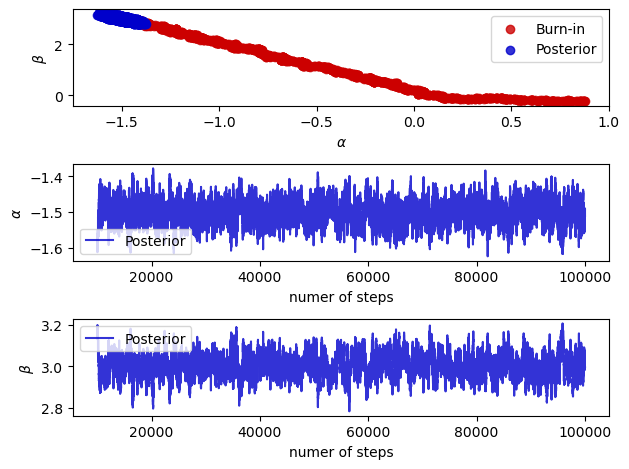

In [18]:
import pdb

# Basic MCMC, 'Random Walk Metropolis' (RWM) adapted to this problem
def RWM(thetacur,thetapro,thetaprim,thetapris,xcur,xpro,yobs,sigy):
#def RWM(phic,phip,Uc,yp,y,Rinv,Cinv):
    # Classic Random Walk Metropolis MCMC algorithm.
    # This is just the "Meteropolis-Hastings" algorithm with a
    # Gaussian proposal (transition) density.
    # Like the "BIS" algorithm, the math simplifies in the case of
    # iid Gaussian observation errors and independent priors.
    # For clarity I have on purpose avoided using more general matrix notation.

    logpricur=-0.5*np.sum(((thetacur-thetaprim)**2)/(thetapris**2))
    logpripro=-0.5*np.sum(((thetapro-thetaprim)**2)/(thetapris**2))
    #pdb.set_trace()

    loglikcur=-0.5*np.sum(((yobs-xcur)**2)/(sigy**2))
    loglikpro=-0.5*np.sum(((yobs-xpro)**2)/(sigy**2))

    logposcur=logpricur+loglikcur
    logpospro=logpripro+loglikpro
    #pdb.set_trace()
    alpha=min(1,np.exp(logpospro-logposcur))
    u=np.random.rand(1)
    accept=(alpha>=u)
    return accept

Ns=int(1e5)
a=np.zeros(Ns)
b=np.zeros(Ns)

sigp=0.01 # Proposal standard deviation

# Optional subsetting to check the effect of varying the amount of data
subsetf=1
Nsub=int(subsetf*Nt)

pris=np.array([sd_a_pri, sd_b_pri])
prim=np.array([mu_a_pri, mu_b_pri])

#a[0]=apostm#amap+0.1
#b[0]=bpostm#bmap+0.1
a[0]=mu_a_pri+sd_a_pri*np.random.randn(1)[0]
b[0]=mu_b_pri+sd_b_pri*np.random.randn(1)[0]


accepted=0
for j in range(Ns-1):
    acur=a[j]
    bcur=b[j]
    thetac=np.array([acur,bcur])
    apro=acur+sigp*np.random.randn(1)[0]
    bpro=bcur+sigp*np.random.randn(1)[0]
    #pdb.set_trace()
    thetap=np.array([apro,bpro])
    thesesub=np.random.choice(Nt,Nsub,replace=False)
    xcur=linear_model(t[thesesub],acur,bcur)
    xpro=linear_model(t[thesesub],apro,bpro)
    accept=RWM(thetac,thetap,prim,pris,xcur,xpro,y[thesesub],sigy)
    if accept==1:
        a[j+1]=apro
        b[j+1]=bpro
        accepted=accepted+1
    else:
        a[j+1]=acur
        b[j+1]=bcur

# Discard burn in
burnf=0.1
Nburn=int(burnf*Ns)
aburn=a[:Nburn]
bburn=b[:Nburn]
a=a[Nburn:]
b=b[Nburn:]


# Plot the chain
fig, (ax1, ax2, ax3) = plt.subplots(3,1)

ax1.scatter(aburn,bburn,color=(0.8,0,0),alpha=0.8,label='Burn-in')
ax1.scatter(a,b,color=(0,0,0.8),alpha=0.8,label='Posterior')
ax1.set_xlabel(r'$\alpha$')
ax1.set_ylabel(r'$\beta$')
ax1.legend()


plotburn=False
ax2.plot(Nburn+np.arange(len(a)),a,color=(0,0,0.8),alpha=0.8,label='Posterior')
if plotburn is True:
    ax2.plot(np.arange(Nburn),aburn,color=(0.8,0,0),alpha=0.8,label='Burn-in')
ax2.set_xlabel(r'numer of steps')
ax2.set_ylabel(r'$\alpha$')
ax2.legend()

ax3.plot(Nburn+np.arange(len(b)),b,color=(0,0,0.8),alpha=0.8,label='Posterior')
if plotburn is True:
    ax3.plot(np.arange(Nburn),bburn,color=(0.8,0,0),alpha=0.8,label='Burn-in')
ax3.set_xlabel(r'numer of steps')
ax3.set_ylabel(r'$\beta$')
ax3.legend()

fig.tight_layout()


# Discard burn in
burnf=0.1
Nburn=int(burnf*Ns)
a=a[Nburn:]
b=b[Nburn:]


It should be clear to say if the chain has "mixed" well (converged) since then it typically just moves around the area of high probability mass in the posterior after the initial exploratory burn-in period. This is usually especially evident in the **trace plots** showing the 'time' evolution of the individual individual parameters across the steps in the chain "trace" where we want to see the parameters reaching some kind of stationary regime that they oscillate around, this ideal behaviour that we look for is something akin to a *hairy caterpillar* which is a name used to describe this mixed regime.


Now let's also output the predictive results of the posterior inference with MCMC, in the same way we did for importance sampling

MCMC posterior mean parameters: alpha=-1.50, beta=3.00
Accepted 77668.00 out of 100000.00 steps


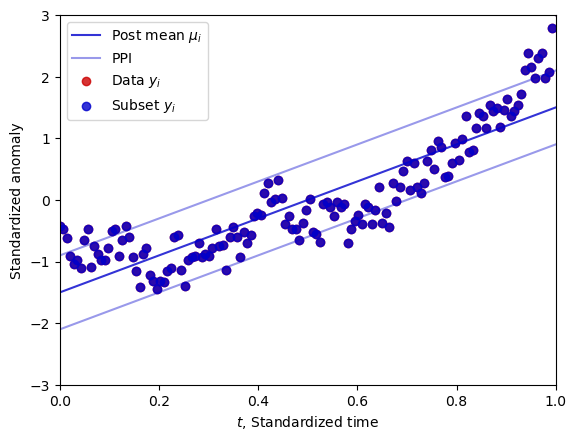

In [19]:
print('MCMC posterior mean parameters: alpha=%4.2f, beta=%4.2f' % (a.mean(),b.mean()))
print('Accepted %4.2f out of %4.2f steps' % (accepted,Ns))


yppi=3*np.sqrt(xpostsd**2+sigy**2)

xpost=linear_model(t,a,b)
xpostm=np.mean(xpost,1)
xpostsd=np.std(xpost,1)



plt.plot(t,xpostm,color=(0,0,0.8),alpha=0.8,label='Post mean $\mu_i$')
plt.plot(t,xpostm+yppi,color=(0,0,0.8),alpha=0.4,label='PPI')
plt.plot(t,xpostm-yppi,color=(0,0,0.8),alpha=0.4)
plt.scatter(t,y,color=(0.8,0,0),alpha=0.8,label='Data $y_i$')
plt.scatter(t[thesesub],y[thesesub],color=(0,0,0.8),alpha=0.8,label='Subset $y_i$')
plt.xlim([0,1])
plt.ylim([-3,3])
#plt.aspect(1/6)
plt.xlabel(r'$t$, Standardized time')
plt.ylabel(r'Standardized anomaly')
plt.legend()

# Nonlinear data assimilation: Flux inversion

The last demonstration here shows how we can use the last two Monte Carlo methods to solve inverse problems that occur often in geophysics using Bayesian data assimilation. For this I have picked a simple model once more, but the problem can easily be generalized to be the much more challenging atmospheric **flux inversion** problem where we try to infer surface fluxes of carbon, water, and or/energy from measurements of atmospheric variables like gas concentrations, wind speed, humidity, and/or air temperature using data from drones or satellites. For more on this more general problem, see for example the recent papers by [Pirk et al. (2022)](https://doi.org/10.5194/amt-15-7293-2022) and [van Hove et al. (2025)](https://doi.org/10.5194/bg-22-4163-2025) where we assimilate drone data in a large eddy simulation and plume models, respectively.

## The law of the wall

To keep things as simple as possible, here we will just restrict our attention to just horizontal wind speed under idealized neutral stratification conditions using the so-called (logarithmic) "law of the wall":


$U(z)=(u_{*}/\kappa)\log(z/z_0)$



which describes how (mean) **wind speed** $U$ increases logarithmically with **height** $z$ in the neutral atmospheric surface layer. The surface layer is the lowest part of the atmospheric boundary layer that is closest to the ground, typically the first 1 (very stable) to 100 (very unstable) or so meters depending on the atmospheric stability. Neutral just means that there is essentially no temperature gradient with height. This empirical law (often including stratification) is also widely used as a boundary condition in general fluid dynamics simulations with physical boundaries.

Here our task is to infer the so-called **friction velocity** $u_{*}=\sqrt{-\overline{u'w'}}$ and the **roughness length** $z_0$ given noisy measurements of the wind speed $U$ at various heights. The friction (or shear) velocity is closely related to the **momentum flux** ($-\overline{u'w'}$) and can be used as a measure of the strength of mechanical turbulence. The roughness length is the theoretical height at $z=z_0$ at which the wind speed $U$ goes to zero. Finally, $\kappa=0.4$ is the von Kármán constant. Thus, we can express our inverse problem mathematically as follows:
$$ \mathbf{y} = \mathcal{G}(\boldsymbol{\theta})+\boldsymbol{\varepsilon} $$
where $\mathbf{y}$ contains observations of the mean wind speed $U$ at various heights, $\mathcal{G}$ is the data generating model (in this case the law of the wall), $\boldsymbol{\theta}$ contains the uncertain parameters ($u_{*}$ and $z_0$), and finally $\boldsymbol{\varepsilon}$ is the noise term representing measurement error where we will use the same independent Gaussian noise model as before. Note that this is the same setup as before with the two last examples where we want to infer the posterior $p(\boldsymbol{\theta}|\mathbf{y})$ as our solution to this inverse problem. The only different now is that the data generating model $\mathcal{G}$ is **non-linear** so we resort to Monte Carlo methods as we are unlikely to be able to find an analytical solution.

Here we will use synthetic (rather than real) data in an identical twin experiment to focus our attention on the algorithms (inference) as opposed to the suitability of the model itself. Note that this simple case is nonetheless readily extended beyond neutral stratification as well as to multiple variables such as air temperature

As a side note, this simple model can be readily extended beyond neutral stratification and to multiple variables such as air temperature and humidity using the so-called Monin-Obukhov Similarity Theory (MOST) as reviewed by [Högström (1996)](https://doi.org/10.1007/BF00120937). This MOST generalization, in turn, is widely used to compute turbulent fluxes that occur in the surface energy and mass balance. As such MOST in some form or anothr in essentially all climate and numerical weather prediction models to couple the (land, ice, or ocean) surface with the atmosphere aloft.



In [20]:
# The "forward model" mapping from hidden parameters (u_s, z_0)
# to the observations in the form of wind profiles U(z)
def LOTW(u_s,z_0,z):
    # The log law-of-the-wall describing idealized mean horizontal wind profiles
    # in the atmospheric surface layer under neutral stability conditions.
    # Input:
    # u_s: Friction velocity [m/s],
    #      the square root of the downwards momentum flux \sqrt(-\bar{u'w'}).
    # z_0: The aerodynamic roughness length [m].
    # z: Altitude above the surface [m]

    kappa=0.4 # von Kármán constant
    U=(u_s/kappa)*np.log(z/z_0) # Log 'law of the wall'
    return U

Now let's generate our "truth" run for a synthetic (twin) experiment like we did for the Blindern climatology with the Gaussian noise model. Here we could also use real measurements of wind speed as well, but for testing numerical methods it is often smart to first start with synthetic experiments where we are in control.

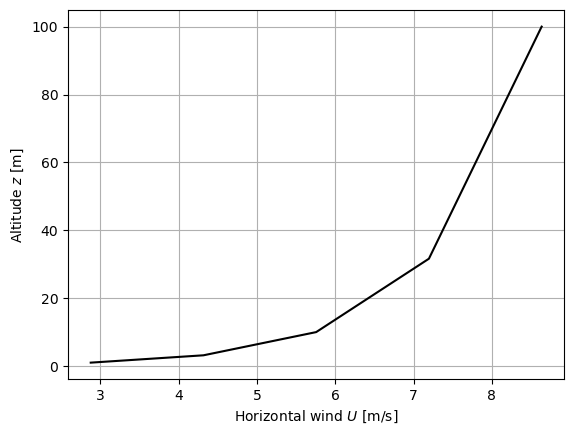

In [21]:
# True parameters (usually uknown in reality)
u_s_true=0.5 # True friction velocity [m/s]
z_0_true=0.1 # True roughness length [m], typical value for low crops

# Altitudes that we want to evaluate the profile for
Nz=5 # Number of measurement levels
z=np.logspace(0,2,Nz) # Nz levels evenly spaced on a log scale from 1 to 50 m

# True profile
U_true=LOTW(u_s_true,z_0_true,z)

# Visualize
fig, ax =plt.subplots()
ax.plot(U_true,z,'k',label='Truth')
ax.set(xlabel='Horizontal wind $U$ [m/s]',ylabel='Altitude $z$ [m]')
ax.grid()

Next, we'll add some **observation error** using a Gaussian noise model to mimic real observations (that are always noisy!)

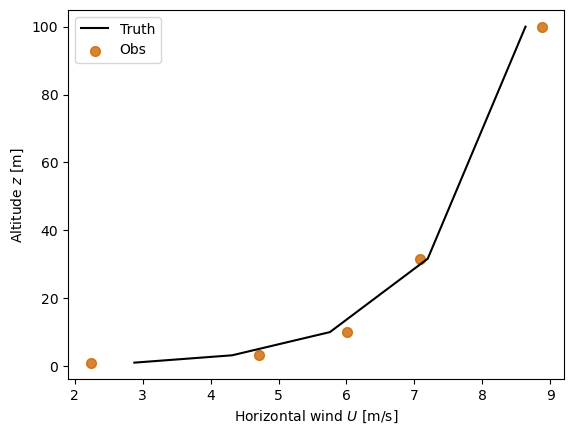

In [22]:
# Add observation error
sigU=1
U_obs=U_true+sigU*np.random.randn(Nz)
U_obs=np.maximum(U_obs,0) # Truncate to avoid negative wind speeds.
fig, ax =plt.subplots()
ax.plot(U_true,z,'k',label='Truth')
ax.set(xlabel='Horizontal wind $U$ [m/s]',ylabel='Altitude $z$ [m]')
ax.scatter(U_obs,z,50,color=(0.8,0.4,0),alpha=0.8,label='Obs')
ax.legend()

This observation error model is equivalent to assuming the by now familiar Gaussian likelihood:
$$p(\mathbf{y}|\boldsymbol{\theta})\propto \exp\left(-\sum_{i=1}^N\frac{(y_i-\mathcal{G}(\boldsymbol{\theta}))^2}{2\sigma_y^2}\right) $$


Now to make this a realistic (and not completely circular) synthetic experiment let's try to forget about the truth run or at least pretend that we don't know the true parameters and that we have not seen the observations yet. Let's formulate our prior, and we will let it be a vague guess on the two parameters reflecting our initial ignorance of what to expect (i.e., before looking at the data). Remember that you can (and are encouraged to) change the prior on the parameters to see how it affects the prior predictions. Remember that by using a prior (and likelihood) we are being objective (in the sense that this is transparent and reproducible) about our subjective assumptions.

[Text(0.5, 0, '$z_0$ [m]\xa0prior')]

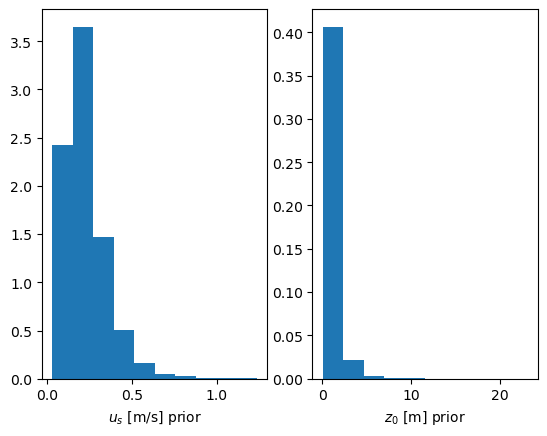

In [23]:
# Prior distributions (log-normal also known as log Gaussian)
Ns=int(1e4) # Number of ensemble members
u_s_prim=np.log(0.2) # Mean of underlying normal dist.
u_s_pris=0.5 # Std of underlying normal dist.
u_s_pri=np.exp(u_s_prim+u_s_pris*np.random.randn(Ns))
z_0_prim=np.log(0.5)
z_0_pris=1
z_0_pri=np.exp(z_0_prim+z_0_pris*np.random.randn(Ns))

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(u_s_pri,density=True)
ax1.set(xlabel='$u_s$ [m/s] prior')
ax2.hist(z_0_pri,density=True)
ax2.set(xlabel='$z_0$ [m] prior')

So other than being positive, the prior friction velocity and aerodynamic roughness length have quite a broad range. Let's see what kind of prior predictions we get

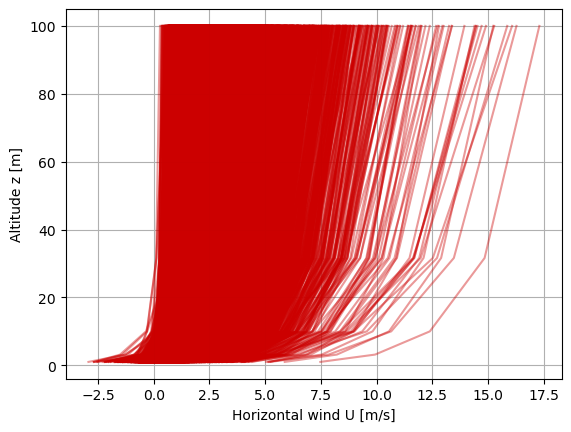

In [24]:
# Prior predictions
u_s_priz=np.tile(u_s_pri,[Nz,1]).T
z_0_priz=np.tile(z_0_pri,[Nz,1]).T
U_pri=LOTW(u_s_priz,z_0_priz,z)

# Visualize
fig, ax =plt.subplots()
ax.plot(U_pri.T,z,color=(0.8, 0, 0),alpha=0.4)
ax.set(xlabel='Horizontal wind U [m/s]',ylabel='Altitude z [m]')
ax.grid()

## Particle-based flux inversion

Let's try and solve the problem using the basic particle method that we introduced earlier.

Posterior parameter mean: alpha=0.54, beta=0.18
Posterior parameter std: alpha=0.07, beta=0.10
True parameters: alpha=0.50, beta=0.10


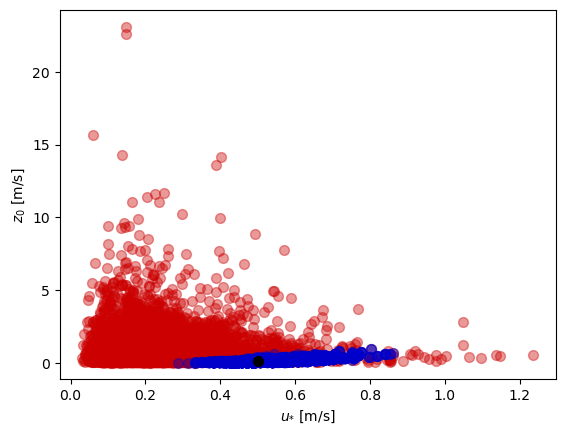

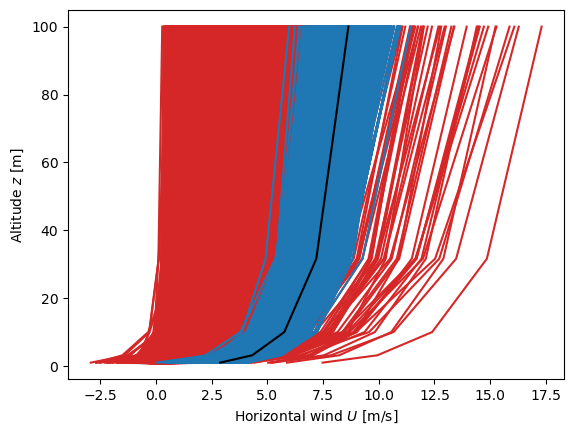

In [25]:
# Posterior estimate from BIS
xpri=np.array([u_s_pri,z_0_pri])
w,Neff=BIS(U_pri.T,U_obs,sigU)

pinds = np.arange(Ns) # Particle/sample indices
reinds = np.random.choice(pinds, Ns, p=w) # Resampling (copy) high weight indices
xpost=xpri[:,reinds] # Resample from prior based on posterior weights to estimate posterior
u_s_post=xpost[0,:]
z_0_post=xpost[1,:]
U_post=U_pri[reinds,:]



# Visualize
fig, ax =plt.subplots()
ax.scatter(u_s_pri,z_0_pri,50,color=(0.8,0,0),alpha=0.4)
ax.scatter(u_s_post,z_0_post,50,color=(0,0,0.8),alpha=0.4)
ax.scatter(u_s_true,z_0_true,50,'k')
ax.set(xlabel='$u_{*}$ [m/s]',ylabel='$z_0$ [m/s]')


fig, ax =plt.subplots()
ax.plot(U_pri.T,z,'tab:red')
ax.plot(U_post.T,z,'tab:blue')
ax.plot(U_true,z,'k')
ax.set(xlabel='Horizontal wind $U$ [m/s]',ylabel='Altitude $z$ [m]')


print('Posterior parameter mean: alpha=%4.2f, beta=%4.2f' % (u_s_post.mean(),z_0_post.mean()))
print('Posterior parameter std: alpha=%4.2f, beta=%4.2f' % (u_s_post.std(),z_0_post.std()))
print('True parameters: alpha=%4.2f, beta=%4.2f' % (u_s_true,z_0_true))

This seems to work well in that the importance sampling is able to essentially recover the unknown synthetic truth parameters. Note that the fact that importance sampling works well here is not surprising given that we do not have that: we have few data points, a large number of samples (particles), and a relatively low dimensional (2D) parameter space.


## Equifinality and joint assimilation

It is both intriguing and typical to see how the posterior does not converge to a clear optimal solution but rather a distribution of equally acceptable solutions that arises due to the limited and noisy data at hand as well as the nonlinear nature of this inverse problem. In fact, this phenomenon known as **equifinality** is ubiquitous in the ill-posed problems that we tend to tackle in geophysics and tends to happen when one has compensating parameters. Equifinality is often ignored or swept under the carpet for example by just picking a single member from the posterior ensemble and ignoring the rest. A more transparent approach is to view this as a feature rather than a bug in the problems we are solving and to embrace the uncertainty as a guide to how one could go about further constraining the solution. One way to do this would be to collect more or different kinds of measurements. Indeed, this idea is at the heart of Bayesian data assimilation where one should not have to pick a single kind of observation but rather use all the observations and background knowledge at hand to solve the problem using **joint data assimilation**.

Continuing with the example above, let's imagine that we have obtained independent observational estimates of the roughness length $z_0$ from a nearby flux tower or a previous study in the area for the land cover in question. We can now extend our DGM beyond the law of the wall to become multivariate and also include a generative model for the logarithm of the roughness length in addition to the wind speed profile. In fact, the new extension to the model can be as simple as adding the first model we dealt with in this notebook, namely $y=x+\epsilon$ where now $x_l$ is the modeled $\log(z_0)$ from the prior and $y_l$ is the observation of $\log(z_0^{(o)})$ from the flux tower. For simplicity we assume $\epsilon\sim N(0,\sigma_y^2)$ where $\sigma_y^2=0.1^2$ is the observation error variance of the logarithm of the roughness length. Now we can use the same code as before but just extend our likelihood by extending $\mathbf{y}$ to also include the observed logarithm of the roughness length and modifying $\sigma_y^2$ to be a vector to account for the difference in observation error for the wind speed and the logarithm of the roughness length.

Posterior parameter mean: alpha=0.38, beta=0.03
Posterior parameter std: alpha=0.04, beta=0.01
True parameters: alpha=0.50, beta=0.10


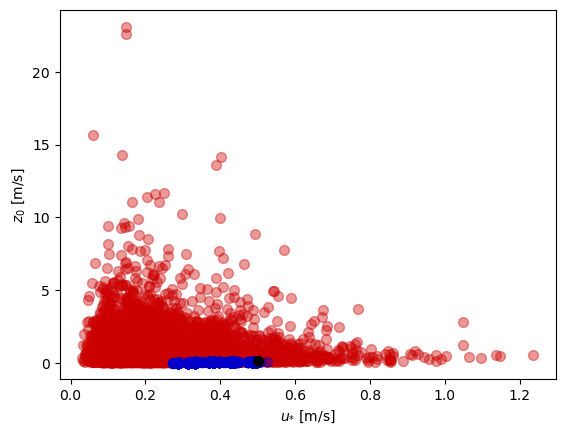

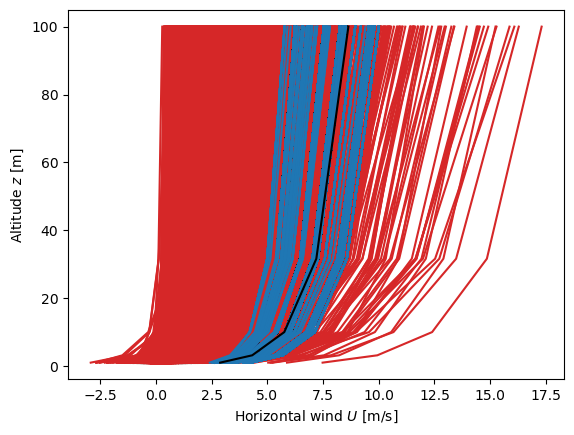

In [26]:
# Posterior estimate from BIS
xpri=np.array([u_s_pri,z_0_pri])

# Synthetic observation of log(z0)
siglz_0=0.1
lz_0_obs=np.log(z_0_true)+siglz_0*np.random.randn(1)

y=np.concatenate((U_obs,lz_0_obs)) # Concatenated observation vector
sigy=np.concatenate((sigU*np.ones(len(U_obs)),siglz_0*np.ones(len(lz_0_obs)))) # error std vector
y_pred=np.concatenate((U_pri.T,z_0_pri[np.newaxis])) # Concatenated predicted obs vector
w,Neff=BIS(y_pred,y,sigy)

pinds = np.arange(Ns) # Particle/sample indices
reinds = np.random.choice(pinds, Ns, p=w) # Resampling (copy) high weight indices
xpost=xpri[:,reinds] # Resample from prior based on posterior weights to estimate posterior
u_s_post=xpost[0,:]
z_0_post=xpost[1,:]
U_post=U_pri[reinds,:]



# Visualize
fig, ax =plt.subplots()
ax.scatter(u_s_pri,z_0_pri,50,color=(0.8,0,0),alpha=0.4)
ax.scatter(u_s_post,z_0_post,50,color=(0,0,0.8),alpha=0.4)
ax.scatter(u_s_true,z_0_true,50,'k')
ax.set(xlabel='$u_{*}$ [m/s]',ylabel='$z_0$ [m/s]')


fig, ax =plt.subplots()
ax.plot(U_pri.T,z,'tab:red')
ax.plot(U_post.T,z,'tab:blue')
ax.plot(U_true,z,'k')
ax.set(xlabel='Horizontal wind $U$ [m/s]',ylabel='Altitude $z$ [m]')


print('Posterior parameter mean: alpha=%4.2f, beta=%4.2f' % (u_s_post.mean(),z_0_post.mean()))
print('Posterior parameter std: alpha=%4.2f, beta=%4.2f' % (u_s_post.std(),z_0_post.std()))
print('True parameters: alpha=%4.2f, beta=%4.2f' % (u_s_true,z_0_true))

### Closing thoughts

Thanks for working through the notebook, hopefully the terms **prior** (first guess), **likelihood** (forward probability), and **posterior** (inverse probability) are starting to make sense now. Remember that these Bayesian techniques can be seen as an extension of optimization that includes uncertainty quantification which you can use for data assimilation, inverse problems, geostatistics, and machine learning tasks. Uncertainty quantification is important because many of these problems are "ill-posed" in the sense that it does not really make sense to consider one solution as optimal in that this is very sensitive to irreducible noise in the data as well as subjective decisions on how you define optima (so-called loss or utility functions). So instead of providing a single solution, through the posterior distribution Bayesian techniques provide a range of possible solutions through that are consistent with the data at hand. These remaining solutions can then be used to make decisions, for example on where to measure next or what to report to a stakeholder.

I hope you were intrigued by these admittedly toy examples to take the plunge into real Bayesian data assimilation problems. As stated in the beginning, feedback and questions are very welcome!